# (Start) Testing Area

# (End) Testing Area

# ----------------------------------

## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser
from unidecode import unidecode
import librosa

D:\Miniconda\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
D:\Miniconda\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
def plot_data(data, title=None):
    %matplotlib inline
    if len(data) > 1:
        fig, axes = plt.subplots(len(data), 1, figsize=(int(alignment_graph_width*graph_scale/100), int(alignment_graph_height*graph_scale/100)))
        axes = axes.flatten()
        for i in range(len(data)):
            if title:
                axes[i].set_title(title[i])
            axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                           interpolation='none', cmap='inferno')
        axes[0].set(xlabel="Frames", ylabel="Channels")
        axes[1].set(xlabel="Decoder timestep", ylabel="Encoder timestep")
    else:
        fig, axes = plt.subplots(len(data), 1, figsize=(int(alignment_graph_width*graph_scale/100), int(alignment_graph_height*graph_scale/100)//2))
        if title:
            plt.title(title)
        axes.imshow(data[0], aspect='auto', origin='bottom', interpolation='none', cmap='inferno')
        axes.set(xlabel="Frames", ylabel="Channels")
    fig.canvas.draw()
    plt.show()

#dictionary_path = r"/media/cookie/Samsung PM961/TwiBot/tacotron2/filelists/merged.dict_.txt"
dictionary_path = r"G:\TwiBot\tacotron2\filelists\merged.dict_.txt"
print("Running, Please wait...")
thisdict = {}
for line in reversed((open(dictionary_path, "r").read()).splitlines()):
    thisdict[(line.split(" ", 1))[0]] = (line.split(" ", 1))[1].strip()
print("Dictionary Ready.")
sym = list("☺☻♥♦♣♠•◘○◙♂♀♪♫☼►◄↕‼¶§▬↨↑↓→←∟↔▲▼")
def ARPA(text_, punc=r"!?,.;:␤#-_'\"()[]"):
    text = text_.replace("\n"," "); out = ''
    for word_ in text.split(" "):
        word=word_; end_chars = ''; start_chars = ''
        while any(elem in word for elem in punc) and len(word) > 1:
            if word[-1] in punc: end_chars = word[-1] + end_chars; word = word[:-1]
            elif word[0] in punc: start_chars = start_chars + word[0]; word = word[1:]
            else: break
        try: word_arpa = thisdict[word.upper()]
        except: word_arpa = ''
        if len(word_arpa)!=0: word = "{" + str(word_arpa) + "}"
        out = (out + " " + start_chars + word + end_chars).strip()
    #if out[-1] != "␤": out = out + "␤"
    #if out[0] != "☺": out = "☺" + out
    return out

Running, Please wait...
Dictionary Ready.


#### Setup hparams

In [3]:
hparams = create_hparams()
hparams.max_decoder_steps = 1000
hparams.gate_threshold = 0.6
hparams.ignore_layers = []
print(str(hparams))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

epochs=1000,iters_per_checkpoint=1000,iters_per_validation=1000,seed=1234,dynamic_loss_scaling=True,fp16_run=False,distributed_run=False,dist_backend=nccl,dist_url=tcp://127.0.0.1:54321,cudnn_enabled=True,cudnn_benchmark=False,ignore_layers=[],load_mel_from_disk=True,speakerlist=/media/cookie/Samsung 860 QVO/ClipperDatasetV2/filelists/speaker_ids.txt,training_files=/media/cookie/Samsung 860 QVO/ClipperDatasetV2/filelists/mel_train_taca2_merged.txt,validation_files=/media/cookie/Samsung 860 QVO/ClipperDatasetV2/filelists/mel_validation_taca2_merged.txt,text_cleaners=['basic_cleaners'],max_wav_value=32768.0,sampling_rate=48000,fil

In [4]:
# allows WaveGlow from Ground Truth
from utils import load_wav_to_torch
stft = TacotronSTFT(hparams.filter_length, hparams.hop_length, hparams.win_length,
                    hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                    hparams.mel_fmax)
def load_mel(path):
    audio, sampling_rate, max_value = load_wav_to_torch(path)
    if sampling_rate != stft.sampling_rate:
        raise ValueError("{} {} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio / max(max_value, audio.max(), -audio.min())
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    return melspec

#### Load Tacotron2 model from checkpoint

In [5]:
checkpoint_path = r"G:\TwiBot\tacotron2-PPP-1.3.0\outdir_truncated1\checkpoint_53000"
print("Loading Tacotron... ", end="")
checkpoint_hparams = torch.load(checkpoint_path)['hparams']
#checkpoint_hparams.parse_json(hparams.to_json())
model = load_model(hparams)
#checkpoint_dict = {k.replace("encoder_speaker_embedding.weight","encoder.encoder_speaker_embedding.weight"): v for k,v in torch.load(checkpoint_path)['state_dict'].items()}
checkpoint_dict = torch.load(checkpoint_path)['state_dict']
model.load_state_dict(checkpoint_dict)
_ = model.cuda().eval().half(); print("Done")

tacotron_speaker_id_lookup = torch.load(checkpoint_path)['speaker_id_lookup']
print("This Tacotron model has been trained for ",torch.load(checkpoint_path)['iteration']," Iterations.")

Loading Tacotron... Done
This Tacotron model has been trained for  53000  Iterations.


In [6]:
print(model)

Tacotron2(
  (embedding): Embedding(179, 512)
  (encoder): Encoder(
    (encoder_speaker_embedding): Embedding(512, 256)
    (convolutions): ModuleList(
      (0): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(768, 384, batch_first=True, bidirectional=True)
    (LReLU): LeakyReLU(negative_slope=0.01)
  )
  (decoder): D

#### Load WaveGlow from Checkpoint

In [7]:
import torch
import json

waveglow_path = r"H:\TTCheckpoints\waveglow\outdir_EfficientSmallGlobalSpeakerEmbeddings\Testing2\best_val_model"
config_fpath = r"H:\TTCheckpoints\waveglow\outdir_EfficientSmallGlobalSpeakerEmbeddings\Testing2\config.json"

# Load config file
with open(config_fpath) as f:
    data = f.read()
config = json.loads(data)
train_config = config["train_config"]
global data_config
data_config = config["data_config"]
global dist_config
dist_config = config["dist_config"]
global waveglow_config
waveglow_config = {
    **config["waveglow_config"], 
    'win_length': data_config['win_length'],
    'hop_length': data_config['hop_length']
}
print(waveglow_config)
print(f"Config File from '{config_fpath}' successfully loaded.")

# import the correct model
if waveglow_config["yoyo"]: # efficient_mode # TODO: Add to Config File
    from efficient_model import WaveGlow
else:
    from glow import WaveGlow

# initialize model
print(f"intializing WaveGlow model... ", end="")
waveglow = WaveGlow(**waveglow_config).cuda()
print(f"Done!")

# load checkpoint from file
print(f"loading WaveGlow checkpoint... ", end="")
checkpoint = torch.load(waveglow_path)
waveglow.load_state_dict(checkpoint['model']) # and overwrite initialized weights with checkpointed weights
waveglow.cuda().eval().half() # move to GPU and convert to half precision
print(f"Done!")
#for k in waveglow.convinv:
#    k.float()
print(f"initializing Denoiser... ", end="")
denoiser = Denoiser(waveglow)
print(f"Done!")
waveglow_iters = torch.load(waveglow_path)['iteration']
print(waveglow_iters, "iterations")

{'yoyo': True, 'yoyo_WN': False, 'n_mel_channels': 160, 'n_flows': 16, 'n_group': 120, 'n_early_every': 16, 'n_early_size': 2, 'memory_efficient': False, 'spect_scaling': False, 'upsample_mode': 'normal', 'WN_config': {'n_layers': 5, 'n_channels': 384, 'kernel_size': 3, 'speaker_embed_dim': 96, 'rezero': False}, 'win_length': 2400, 'hop_length': 600}
Config File from 'H:\TTCheckpoints\waveglow\outdir_EfficientSmallGlobalSpeakerEmbeddings\Testing2\config.json' successfully loaded.
intializing WaveGlow model... Done!
loading WaveGlow checkpoint... Done!
initializing Denoiser... 

D:\Miniconda\lib\site-packages\torch\nn\functional.py:2973: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Done!
278000 iterations


#### (Option 1) Get Speaker ID's from checkpoint

In [8]:
# tacotron_speaker_id_lookup
waveglow_speaker_id_lookup = checkpoint['speaker_lookup']
print(str(waveglow_speaker_id_lookup).replace(",","\n").replace(":"," ->"))

{0 -> 0
 1 -> 1
 10 -> 2
 100 -> 3
 101 -> 4
 102 -> 5
 103 -> 6
 104 -> 7
 105 -> 8
 106 -> 9
 107 -> 10
 108 -> 11
 109 -> 12
 11 -> 13
 110 -> 14
 111 -> 15
 112 -> 16
 113 -> 17
 114 -> 18
 115 -> 19
 116 -> 20
 117 -> 21
 118 -> 22
 119 -> 23
 12 -> 24
 120 -> 25
 121 -> 26
 122 -> 27
 123 -> 28
 124 -> 29
 125 -> 30
 126 -> 31
 127 -> 32
 128 -> 33
 129 -> 34
 13 -> 35
 130 -> 36
 131 -> 37
 132 -> 38
 133 -> 39
 134 -> 40
 135 -> 41
 136 -> 42
 137 -> 43
 138 -> 44
 139 -> 45
 14 -> 46
 140 -> 47
 141 -> 48
 142 -> 49
 143 -> 50
 144 -> 51
 145 -> 52
 146 -> 53
 147 -> 54
 148 -> 55
 149 -> 56
 15 -> 57
 150 -> 58
 151 -> 59
 152 -> 60
 153 -> 61
 154 -> 62
 155 -> 63
 156 -> 64
 157 -> 65
 158 -> 66
 159 -> 67
 16 -> 68
 160 -> 69
 161 -> 70
 162 -> 71
 163 -> 72
 164 -> 73
 165 -> 74
 166 -> 75
 167 -> 76
 168 -> 77
 169 -> 78
 17 -> 79
 170 -> 80
 171 -> 81
 172 -> 82
 173 -> 83
 174 -> 84
 175 -> 85
 176 -> 86
 177 -> 87
 178 -> 88
 179 -> 89
 18 -> 90
 180 -> 91
 181 -> 92


#### (Option 2) Rebuild Speaker ID's from training filelist

In [9]:
#from data_utils import TextMelLoader
#from difflib import get_close_matches

In [10]:
#speaker_ids = TextMelLoader("/media/cookie/Samsung 860 QVO/ClipperDatasetV2/filelists/mel_train_taca2.txt", hparams).speaker_ids
#speaker_ids = TextMelLoader(r"D:\ClipperDatasetV2/filelists/mel_train_taca2.txt", hparams, check_files=False, TBPTT=False).speaker_ids
#print(str(speaker_ids).replace(", ","\n"))

#### Load TorchMoji for Style Tokens

In [11]:
# -*- coding: utf-8 -*-

""" Use torchMoji to score texts for emoji distribution.

The resulting emoji ids (0-63) correspond to the mapping
in emoji_overview.png file at the root of the torchMoji repo.

Writes the result to a csv file.
"""
import json
import numpy as np
import os

from torchmoji.sentence_tokenizer import SentenceTokenizer
from torchmoji.model_def import torchmoji_feature_encoding
from torchmoji.global_variables import PRETRAINED_PATH, VOCAB_PATH

print('Tokenizing using dictionary from {}'.format(VOCAB_PATH))
with open(VOCAB_PATH, 'r') as f:
    vocabulary = json.load(f)

maxlen = 180
texts = ["Testing!",]

with torch.no_grad():
    st = SentenceTokenizer(vocabulary, maxlen, ignore_sentences_with_only_custom=True)
    torchmoji = torchmoji_feature_encoding(PRETRAINED_PATH)
    tokenized, _, _ = st.tokenize_sentences(texts) # input array [B] e.g: ["Test?","2nd Sentence!"]
    embedding = torchmoji(tokenized) # returns np array [B, Embed]
    print(embedding)

Tokenizing using dictionary from G:\TwiBot\tacotron2-PPP-1.3.0/torchmoji/model/vocabulary.json
Loading weights for embed.weight
Loading weights for lstm_0.weight_ih_l0
Loading weights for lstm_0.weight_hh_l0
Loading weights for lstm_0.bias_ih_l0
Loading weights for lstm_0.bias_hh_l0
Loading weights for lstm_0.weight_ih_l0_reverse
Loading weights for lstm_0.weight_hh_l0_reverse
Loading weights for lstm_0.bias_ih_l0_reverse
Loading weights for lstm_0.bias_hh_l0_reverse
Loading weights for lstm_1.weight_ih_l0
Loading weights for lstm_1.weight_hh_l0
Loading weights for lstm_1.bias_ih_l0
Loading weights for lstm_1.bias_hh_l0
Loading weights for lstm_1.weight_ih_l0_reverse
Loading weights for lstm_1.weight_hh_l0_reverse
Loading weights for lstm_1.bias_ih_l0_reverse
Loading weights for lstm_1.bias_hh_l0_reverse
Loading weights for attention_layer.attention_vector
Ignoring weights for output_layer.0.weight
Ignoring weights for output_layer.0.bias
[[ 0.00398057  0.01723153 -0.01075205 ... -0.01

Define a measure for Alignment quality in inferred clips.

In [12]:
def get_mask_from_lengths(lengths, max_len=None):
    if not max_len:
        max_len = torch.max(lengths).long()
    ids = torch.arange(0, max_len, device=lengths.device, dtype=torch.int64)
    mask = (ids < lengths.unsqueeze(1))
    return mask

# New MUCH more performant version, (doesn't support unique padded inputs, just iterate over the batch dim or smthn if you need padded inputs cause this is still way faster)
# @torch.jit.script # should work and be even faster, but makes it harder to debug and it's already fast enough right now
def alignment_metric(alignments, input_lengths=None, output_lengths=None, average_across_batch=False):
    alignments = alignments.transpose(1,2) # [B, dec, enc] -> [B, enc, dec]
    # alignments [batch size, x, y]
    # input_lengths [batch size] for len_x
    # output_lengths [batch size] for len_y
    if input_lengths == None:
        input_lengths =  torch.ones(alignments.size(0), device=alignments.device)*(alignments.shape[1]-1) # [B] # 147
    if output_lengths == None:
        output_lengths = torch.ones(alignments.size(0), device=alignments.device)*(alignments.shape[2]-1) # [B] # 767
    batch_size = alignments.size(0)
    optimums = torch.sqrt(input_lengths.double()**2 + output_lengths.double()**2).view(batch_size)
    
    # [B, enc, dec] -> [B, dec], [B, dec]
    values, cur_idxs = torch.max(alignments, 1) # get max value in column and location of max value
    
    cur_idxs = cur_idxs.float()
    prev_indx = torch.cat((cur_idxs[:,0][:,None], cur_idxs[:,:-1]), dim=1) # shift entire tensor right by one.
    dist = ((prev_indx - cur_idxs).pow(2) + 1).pow(0.5)
    dist.masked_fill_(~get_mask_from_lengths(output_lengths, max_len=dist.size(1)), 0.0) # remove padding
    dist = dist.sum(dim=(1)) # remove padding
    diagonalitys = (dist + 1.4142135)/optimums # remove padding
    
    alignments.masked_fill_(~get_mask_from_lengths(output_lengths, max_len=alignments.size(2))[:,None,:], 0.0)
    encoder_max_focus = torch.sum(alignments, dim=2).max(dim=1)[0] # [B, enc, dec] -> [B, sum_enc] -> [B]
    encoder_min_focus = torch.sum(alignments, dim=2).min(dim=1)[0]
    encoder_avg_focus = torch.sum(alignments, dim=2).mean(dim=1)
    
    values.masked_fill_(~get_mask_from_lengths(output_lengths, max_len=values.size(1)), 0.0) # because padding
    avg_prob = values.mean(dim=1)
    avg_prob *= (alignments.size(2)/output_lengths.float()) # because padding
    
    if average_across_batch:
        diagonalitys = diagonalitys.mean()
        encoder_max_focus = encoder_max_focus.mean()
        encoder_min_focus = encoder_min_focus.mean()
        encoder_avg_focus = encoder_avg_focus.mean()
        avg_prob = avg_prob.mean()
    return diagonalitys.cpu(), avg_prob.cpu(), encoder_max_focus.cpu(), encoder_min_focus.cpu(), encoder_avg_focus.cpu()

#### Synthesize audio (From Filelist)

0/8|2020-05-22 09:10:32.004584
raw_text:
0: 'Mmmmmmmmmmmmmmmmmmmmmmmm, that feels nice.'
model_input:
0: 'Mmmmmmmmmmmmmmmmmmmmmmmm, {DH AE1 T} {F IY1 L Z} {N IY1 S}.'
Running Tacotron2... Done
Running WaveGlow... Done
Score: 0.493		Stats: 1.242 58.98% 0.4928 0.03 0|  Verified: [1.078557363193777, 0.591796875, 25.6875, 2.22265625, 5.5390625]


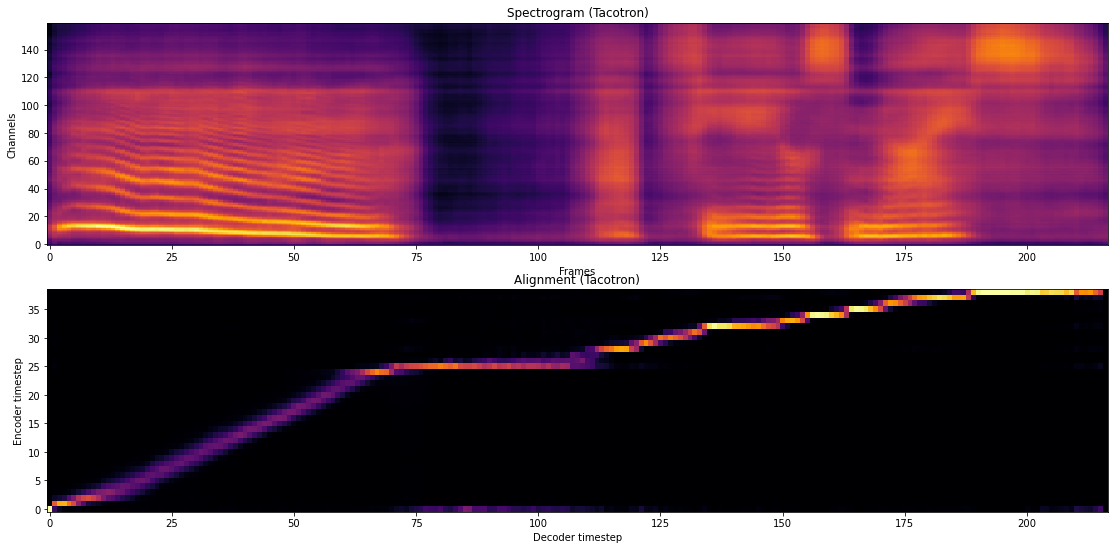

File already found at [D:\Downloads\infer\testing\audio_00_00000.wav], overwriting.
Saving clip to [D:\Downloads\infer\testing\audio_00_00000.wav]... Done


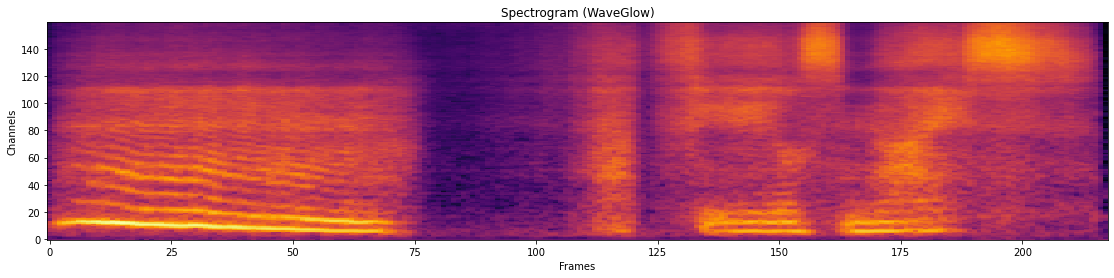

Took 3.149s to generate 2.75s of audio. (best of 128 tries)

1/8|2020-05-22 09:10:35.195500
raw_text:
0: 'Mmmmmmmmmmmmmmmmmmm, that feels nice.'
model_input:
0: 'Mmmmmmmmmmmmmmmmmmm, {DH AE1 T} {F IY1 L Z} {N IY1 S}.'
Running Tacotron2... Done
Running WaveGlow... Done
Score: 0.486		Stats: 1.194 53.86% 0.4861 0.01 0|  Verified: [1.060097629444558, 0.5400390625, 21.5, 2.533203125, 6.765625]


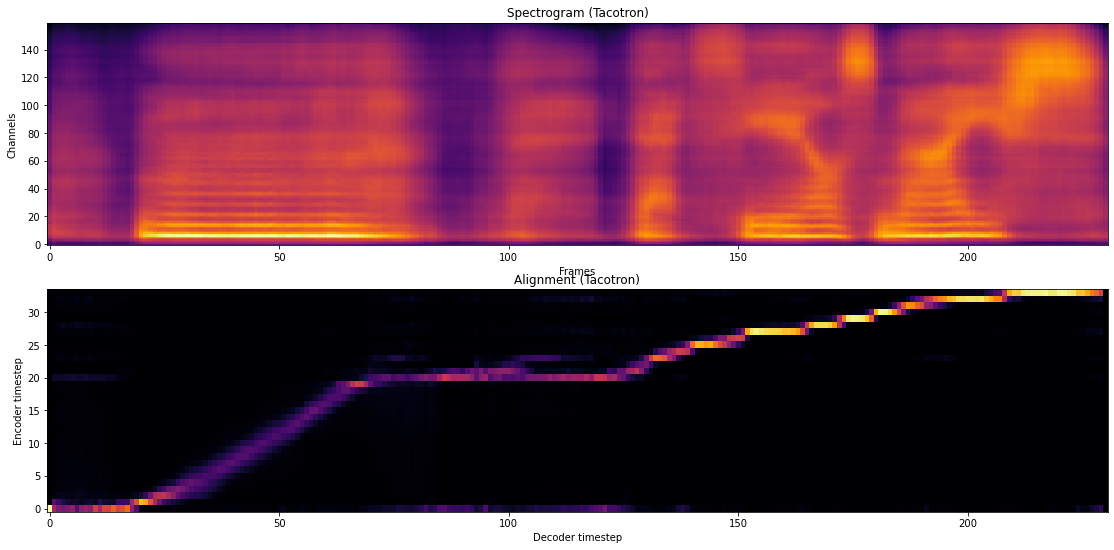

File already found at [D:\Downloads\infer\testing\audio_00_00001.wav], overwriting.
Saving clip to [D:\Downloads\infer\testing\audio_00_00001.wav]... Done


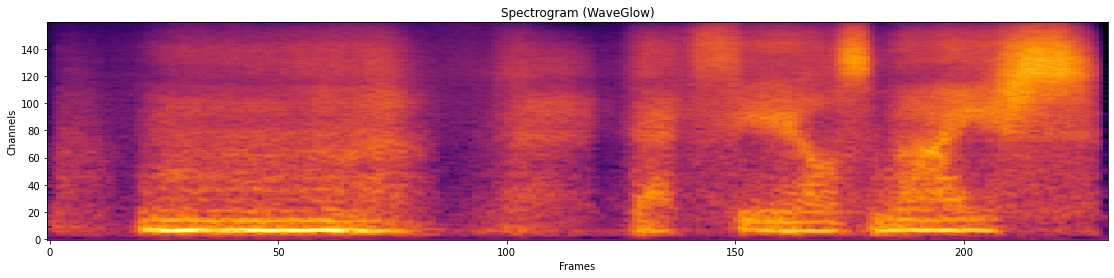

Took 2.944s to generate 2.925s of audio. (best of 128 tries)

2/8|2020-05-22 09:10:38.165225
raw_text:
0: 'Mmmmmmmmmmmmmmm, that feels nice.'
model_input:
0: 'Mmmmmmmmmmmmmmm, {DH AE1 T} {F IY1 L Z} {N IY1 S}.'
Running Tacotron2... Done
Running WaveGlow... Done
Score: 0.532		Stats: 1.204 61.33% 0.5315 0.03 0|  Verified: [1.0629133091334517, 0.6171875, 26.1875, 2.365234375, 6.30078125]


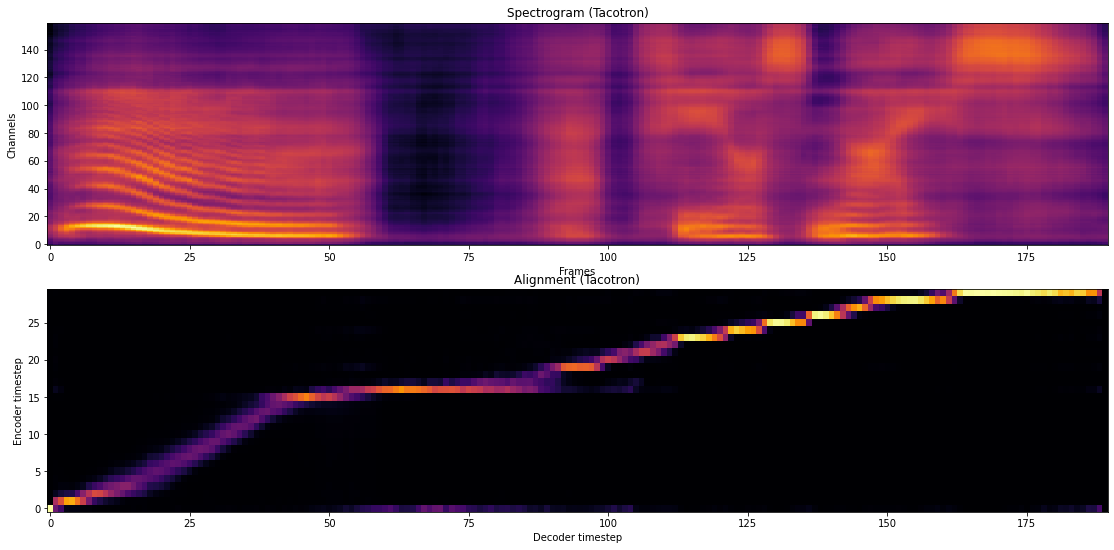

File already found at [D:\Downloads\infer\testing\audio_00_00002.wav], overwriting.
Saving clip to [D:\Downloads\infer\testing\audio_00_00002.wav]... Done


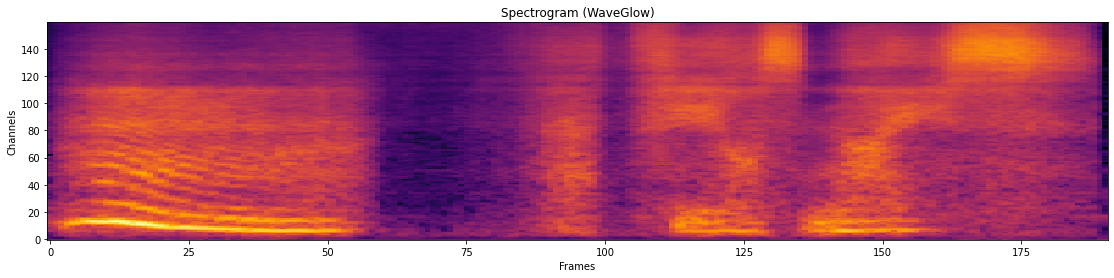

Took 2.744s to generate 2.413s of audio. (best of 128 tries)

3/8|2020-05-22 09:10:40.938173
raw_text:
0: 'Mmmmmmmmmmmm that feels nice.'
model_input:
0: 'Mmmmmmmmmmmm {DH AE1 T} {F IY1 L Z} {N IY1 S}.'
Running Tacotron2... Done
Running WaveGlow... Done
Score: 0.4		Stats: 1.364 52.69% 0.3998 0.0 0|  Verified: [1.1996530944692347, 0.52685546875, 19.03125, 0.99609375, 5.15234375]


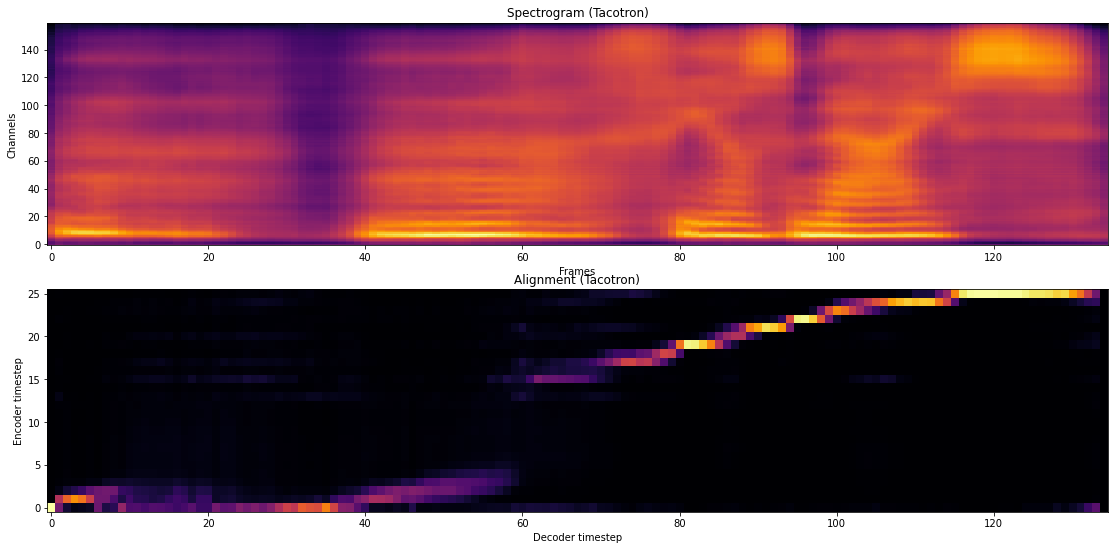

File already found at [D:\Downloads\infer\testing\audio_00_00003.wav], overwriting.
Saving clip to [D:\Downloads\infer\testing\audio_00_00003.wav]... Done


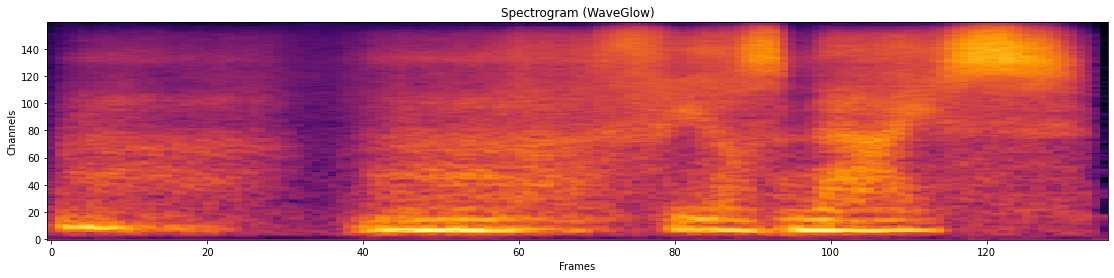

Took 2.212s to generate 1.725s of audio. (best of 128 tries)

4/8|2020-05-22 09:10:43.173035
raw_text:
0: 'Mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm that feels nice.'
model_input:
0: 'Mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm {DH AE1 T} {F IY1 L Z} {N IY1 S}.'
Running Tacotron2... Done
Running WaveGlow... Done
Score: -0.521		Stats: 1.59 36.16% -0.5209 0.13 0.51|  Verified: [1.3095187470293699, 0.360107421875, 43.9375, 0.3798828125, 3.125]


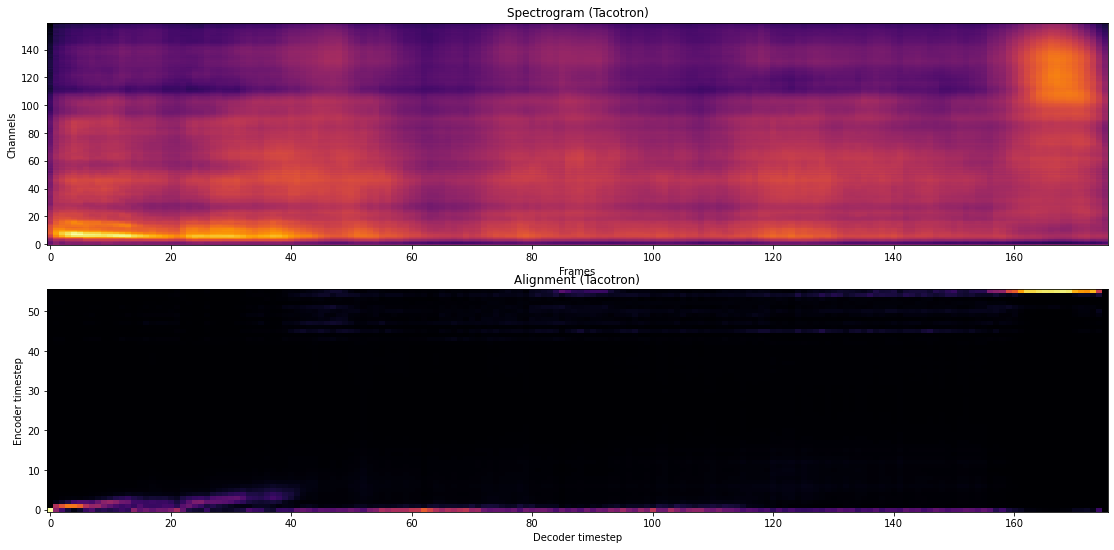

File already found at [D:\Downloads\infer\testing\audio_00_00004.wav], overwriting.
Saving clip to [D:\Downloads\infer\testing\audio_00_00004.wav]... Done


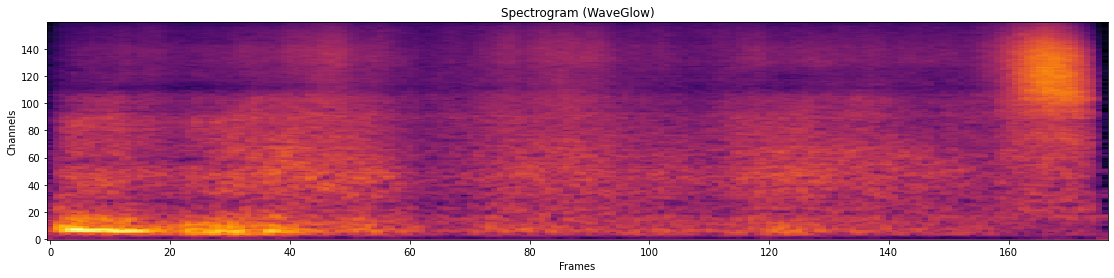

Took 2.406s to generate 2.237s of audio. (best of 128 tries)

5/8|2020-05-22 09:10:45.600768
raw_text:
0: 'Mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm that feels nice.'
model_input:
0: 'Mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm {DH AE1 T} {F IY1 L Z} {N IY1 S}.'
Running Tacotron2... Done
Running WaveGlow... Done
Score: 0.403		Stats: 1.228 47.68% 0.4026 0.02 0|  Verified: [1.063099675018768, 0.4775390625, 22.140625, 2.17578125, 5.51953125]


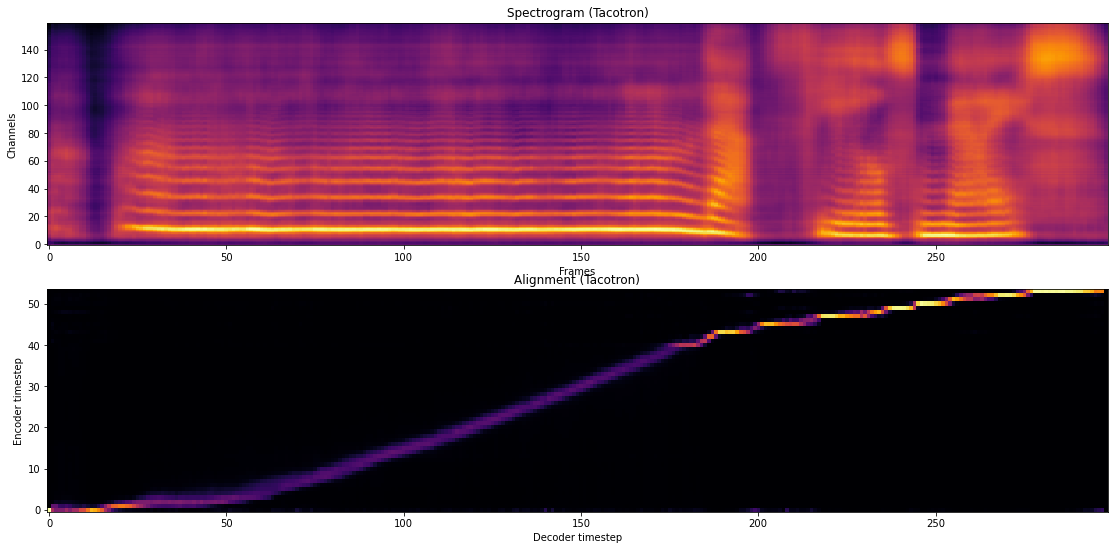

File already found at [D:\Downloads\infer\testing\audio_00_00005.wav], overwriting.
Saving clip to [D:\Downloads\infer\testing\audio_00_00005.wav]... Done


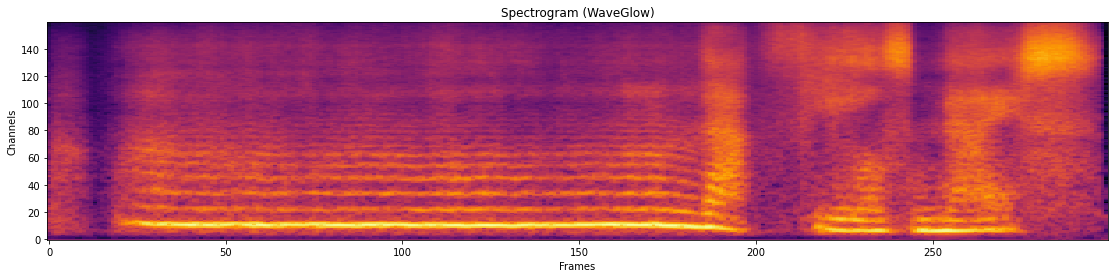

Took 2.935s to generate 3.775s of audio. (best of 128 tries)

6/8|2020-05-22 09:10:48.560728
raw_text:
0: 'Mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm that feels nice.'
model_input:
0: 'Mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm {DH AE1 T} {F IY1 L Z} {N IY1 S}.'
Running Tacotron2... Done
Running WaveGlow... Done
Score: -0.163		Stats: 1.901 35.47% -0.1633 0.12 0|  Verified: [1.9212929081325127, 0.353515625, 42.90625, 0.92236328125, 3.599609375]


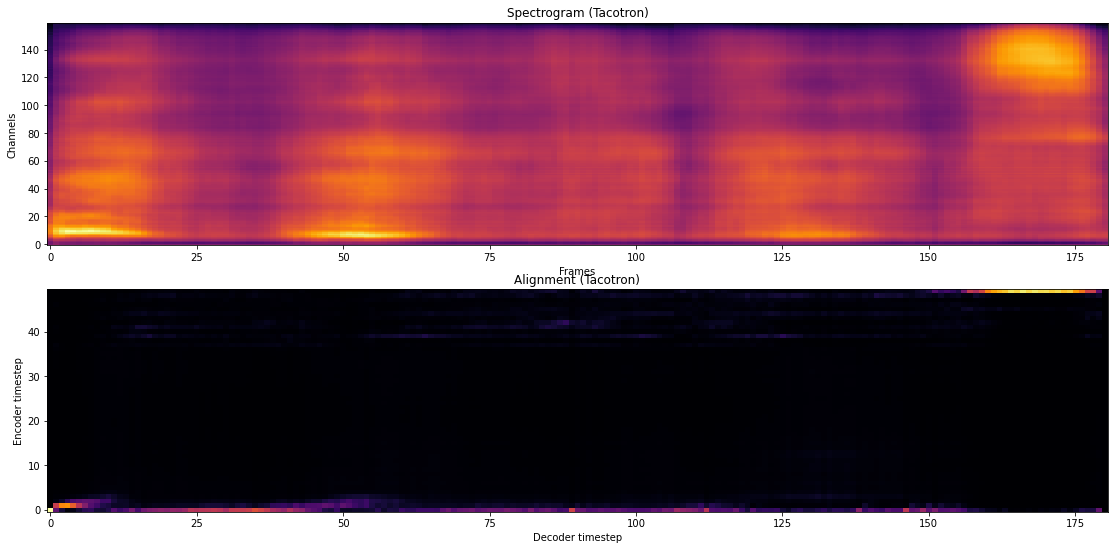

File already found at [D:\Downloads\infer\testing\audio_00_00006.wav], overwriting.
Saving clip to [D:\Downloads\infer\testing\audio_00_00006.wav]... Done


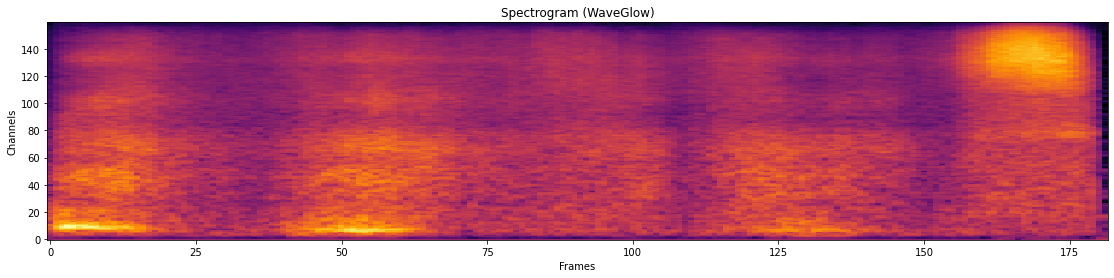

Took 2.26s to generate 2.3s of audio. (best of 128 tries)

7/8|2020-05-22 09:10:50.844418
raw_text:
0: 'Mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm that feels nice.'
model_input:
0: 'Mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm {DH AE1 T} {F IY1 L Z} {N IY1 S}.'
Running Tacotron2... Done
Running WaveGlow... Done
Score: -0.148		Stats: 1.344 44.82% -0.1476 0.02 0.46|  Verified: [1.1120724808319058, 0.447998046875, 23.90625, 0.431884765625, 3.84375]


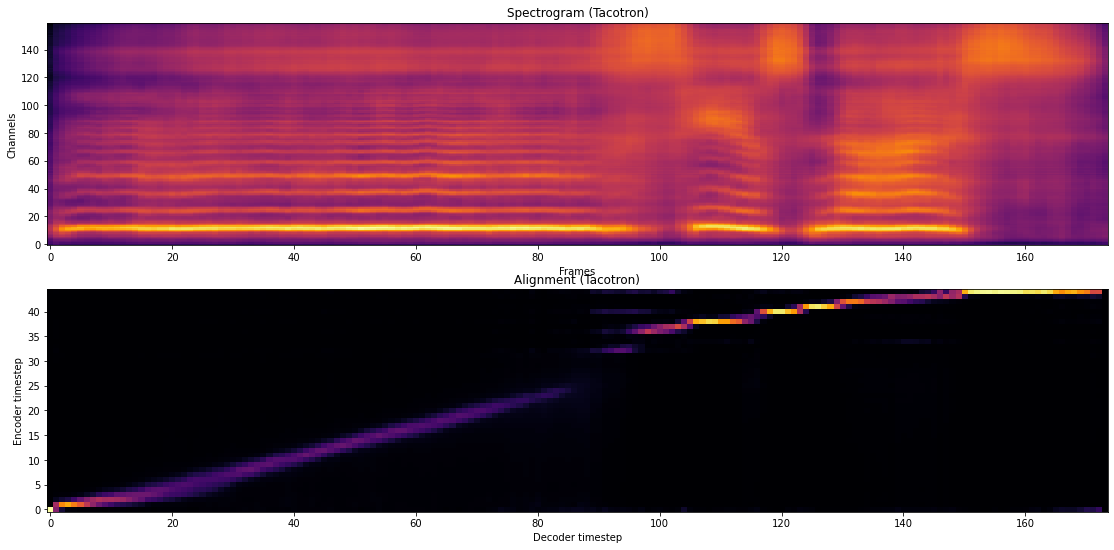

File already found at [D:\Downloads\infer\testing\audio_00_00007.wav], overwriting.
Saving clip to [D:\Downloads\infer\testing\audio_00_00007.wav]... Done


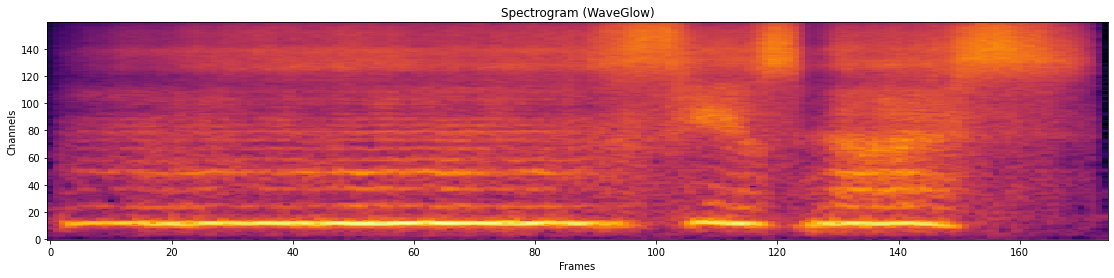

Took 5.047s to generate 2.212s of audio. (best of 128 tries)

Merging audio files 0 to 299... Done
Saving output to 'D:\Downloads\infer\testing\TestingOutput.wav'... Done.


In [111]:
from unidecode import unidecode
import random
from datetime import datetime
import time
from time import sleep
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False

"""
|(Game) Them's Fightin' Herds_Oleander|150
|(Game) Them's Fightin' Herds_Fred|151
|(Game) Them's Fightin' Herds_Pom|152
|(Game) Them's Fightin' Herds_Velvet|153
|(Game) Them's Fightin' Herds_Arizona|154
|(Game) Them's Fightin' Herds_Tianhuo|155
|(Game) Elite Dangerous_Eli|156
|(Audiobook) A Little Bit Wicked_Skystar|157
|(Audiobook) Dr. Who_Doctor|158
|(Show) My Little Pony_Applejack|159
|(Show) My Little Pony_Rainbow|160
|(Show) My Little Pony_Pinkie|161
|(Show) My Little Pony_Rarity|162
|(Show) My Little Pony_Spike|163
|(Show) My Little Pony_Fluttershy|164
|(Show) My Little Pony_Nightmare Moon|165
|(Show) Dan Vs_Dan|166
|(Show) My Little Pony_Twilight|167
|(Show) My Little Pony_Scootaloo|168
|(Show) My Little Pony_Big Mac|169
|(Show) My Little Pony_Sweetie Belle|170
|(Show) My Little Pony_Apple Bloom|171
"""

speakers = """
|(Show) My Little Pony_Twilight|167
""".replace("_",", ").replace("("," ").replace(")",", ").split("\n")[1:-1]

narrators = """
|(Audiodrama) Fallout Equestria_Littlepip|1
|(Game) Them's Fightin' Herds_Oleander|150
|(Game) Them's Fightin' Herds_Pom|152
|(Game) Them's Fightin' Herds_Velvet|153
|(Game) Them's Fightin' Herds_Arizona|154
|(Game) Them's Fightin' Herds_Tianhuo|155
|(Show) My Little Pony_Applejack|159
|(Show) My Little Pony_Rainbow|160
|(Show) My Little Pony_Pinkie|161
|(Show) My Little Pony_Rarity|162
|(Show) My Little Pony_Spike|163
|(Show) My Little Pony_Fluttershy|164
|(Show) Dan Vs_Dan|166
|(Show) My Little Pony_Twilight|167
|(Show) My Little Pony_Scootaloo|168
|(Show) My Little Pony_Sweetie Belle|170
|(Show) My Little Pony_Apple Bloom|171
""".replace("_",", ").replace("("," ").replace(")",", ").split("\n")[1:-1]

texts = """
Mmmmmmmmmmmmmmmmmmmmmmmm, that feels nice.
Mmmmmmmmmmmmmmmmmmm, that feels nice.
Mmmmmmmmmmmmmmm, that feels nice.
Mmmmmmmmmmmm that feels nice.
Mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm that feels nice.
Mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm that feels nice.
Mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm that feels nice.
Mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm that feels nice.
"""
_audio_path_override = None
_speaker_id_override = None
style_mode = 'torchmoji_hidden' # Options = 'mel','token','zeros','torchmoji_hidden','torchmoji_string'

acceptable_score = 0.8 # sufficient score to just skip ahead instead of checking/generating more outputs
absolutely_required_score = 0.3 # retry forever until this score is reached
absolute_maximum_tries = 256 # this is per text text input

# Score Parameters
diagonality_weighting = 0.5 # 'stutter factor', a penalty for clips where the model jumps back and forwards in the sentence.
max_focus_weighting = 1.0   # 'stuck factor', a penalty for clips that spend execisve time on the same letter.
min_focus_weighting = 1.0   # 'miniskip factor', a penalty for skipping/ignoring small parts of the input text.
avg_focus_weighting = 1.0   # 'skip factor', a penalty for skipping very large parts of the input text
max_attempts = 128 # retries at each clip # this is per text input
batch_size_per_text = 128 # minibatch_size per unique text input
simultaneous_texts = 1 # num unique text inputs per batch

max_decoder_steps = 1600
max_text_segment_length = 120
gate_threshold = 0.7
gate_delay = 3
use_arpabet = 1

sigma = 0.95
audio_save_path = r"D:\Downloads\infer\testing"
output_filename = 'TestingOutput'
save_wavs = 1 # saves wavs to infer folder

show_all_attempt_scores = 0
show_audio_overwrite_warnings = 1
show_input_text = 1
show_best_score = 1
show_audio  = 1
show_graphs_tacotron = 1
show_graphs_waveglow = 1
status_updates = 1 # ... Done
time_to_gen = 1
graph_scale = 0.5
alignment_graph_width = 3840
alignment_graph_height = 1920

model.decoder.gate_delay = gate_delay
model.decoder.max_decoder_steps = max_decoder_steps
model.decoder.gate_threshold = gate_threshold

os.makedirs(audio_save_path, exist_ok=True)
texts_segmented = [x for x in texts.split("\n") if len(x.strip())]
total_len = len(texts_segmented)

continue_from = 0 # skip
counter = 0
text_batch_in_progress = []
for text_index, text in enumerate(texts_segmented):
    if text_index < continue_from: print(f"Skipping {text_index}.\t",end=""); counter+=1; continue
    print(f"{text_index}/{total_len}|{datetime.now()}")
    
    # setup the text batches
    text_batch_in_progress.append(text)
    if (len(text_batch_in_progress) == simultaneous_texts) or (text_index == (len(texts_segmented)-1)): # if text batch ready or final input
        text_batch = text_batch_in_progress
        text_batch_in_progress = []
        if (text_index == (len(texts_segmented)-1)): # if final text input
            simultaneous_texts = len(text_batch) # ensure batch size is still correct
    else:
        continue # if batch not ready, add another text
    
    # pick the speakers for the texts
    speaker_ids = [random.choice(speakers).split("|")[2] if ('"' in text) else random.choice(narrators).split("|")[2] for text in text_batch] # pick speaker if quotemark in text, else narrator
    text_batch  = [text.replace('"',"") for text in text_batch] # remove quotes from text
    
    if _audio_path_override != None:
        audio_path = _audio_path_override
    if _speaker_id_override != None:
        speaker_id = _speaker_id_override
    
    # get speaker_ids (tacotron)
    tacotron_speaker_ids = [tacotron_speaker_id_lookup[int(speaker_id)] for speaker_id in speaker_ids]
    tacotron_speaker_ids = torch.LongTensor(tacotron_speaker_ids).cuda().repeat_interleave(batch_size_per_text)
    
    # get speaker_ids (waveglow)
    waveglow_speaker_ids = [waveglow_speaker_id_lookup[int(speaker_id)] for speaker_id in speaker_ids]
    waveglow_speaker_ids = torch.LongTensor(waveglow_speaker_ids).cuda()
    
    # style
    if style_mode == 'mel':
        mel = load_mel(audio_path.replace(".npy",".wav")).cuda().half()
        style_input = mel
    elif style_mode == 'token':
        pass
        #style_input =
    elif style_mode == 'zeros':
        style_input = None
    elif style_mode == 'torchmoji_hidden':
        try:
            tokenized, _, _ = st.tokenize_sentences(text_batch) # input array [B] e.g: ["Test?","2nd Sentence!"]
        except:
            raise Exception(f"text\n{text_batch}\nfailed to tokenize.")
        try:
            embedding = torchmoji(tokenized) # returns np array [B, Embed]
        except Exception as ex:
            print(f'Exception: {ex}')
            print(f"text: {text_batch} failed to process.")
            #raise Exception(f"text\n{text}\nfailed to process.")
        style_input = torch.from_numpy(embedding).cuda().half().repeat_interleave(batch_size_per_text, dim=0)
    elif style_mode == 'torchmoji_string':
        style_input = text_batch
        raise NotImplementedError
    else:
        raise NotImplementedError
    
    # check punctuation
    valid_last_char = '-,.?!;:' # valid final characters in texts
    text_batch = [text+'.' if (text[-1] not in ',.?!;:') else text for text in text_batch]
    
    # parse text
    text_batch = [unidecode(text.replace("...",". ").replace("  "," ").strip()) for text in text_batch] # remove eclipses, double spaces, unicode and spaces before/after the text.
    if show_input_text: # debug
        print("raw_text:\n", "\n".join([str(j)+': \''+text+'\'' for j, text in enumerate(text_batch)]), sep='')
    if use_arpabet: # convert texts to ARPAbet (phonetic) versions.
        text_batch = [ARPA(text) for text in text_batch]
    if show_input_text: # debug
        print("model_input:\n", "\n".join([str(j)+': \''+text+'\'' for j, text in enumerate(text_batch)]), sep='')
    
    with torch.no_grad():
        if time_to_gen:
            start_time = time.time()
        
        # convert texts to sequence, pad where appropriate and move to GPU
        sequence_split = [torch.LongTensor(text_to_sequence(text, ['english_cleaners'])) for text in text_batch] # convert texts to numpy representation
        text_lengths = torch.tensor([seq.size(0) for seq in sequence_split])
        max_len = text_lengths.max().item()
        sequence = torch.zeros(text_lengths.size(0), max_len).long() # create large tensor to move each text input into
        for i in range(text_lengths.size(0)): # move each text into padded input tensor
            sequence[i, :sequence_split[i].size(0)] = sequence_split[i]
        sequence = sequence.cuda().long().repeat_interleave(batch_size_per_text, dim=0) # move to GPU and repeat text
        text_lengths = text_lengths.cuda().long() # move to GPU
        #print("max_len =", max_len) # debug
        #print( get_mask_from_lengths(text_lengths).shape ) # debug
        #sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long().repeat_interleave(batch_size_per_text, 0)# convert numpy to tensor and repeat for each text
        
        # debug
        text_lengths = text_lengths.clone()
        sequence = sequence.clone()
        
        for i in range(1):
            try:
                best_score = np.ones(simultaneous_texts) * -9e9
                tries      = np.zeros(simultaneous_texts)
                best_generations = [0]*simultaneous_texts
                best_score_str = ['']*simultaneous_texts
                while np.amin(best_score) < acceptable_score:
                    # run inference
                    if status_updates: print("Running Tacotron2... ", end='')
                    mel_batch_outputs, mel_batch_outputs_postnet, gate_batch_outputs, alignments_batch = model.inference(sequence, tacotron_speaker_ids, style_input=style_input, style_mode=style_mode, text_lengths=text_lengths.repeat_interleave(batch_size_per_text, dim=0))
                    
                    # find metrics for each item
                    gate_batch_outputs[:,:20] = 0 # ignore gate predictions for the first 0.05s
                    output_lengths = gate_batch_outputs.argmax(dim=1)+gate_delay
                    diagonality_batch, avg_prob_batch, enc_max_focus_batch, enc_min_focus_batch, enc_avg_focus_batch = alignment_metric(alignments_batch, input_lengths=text_lengths.repeat_interleave(batch_size_per_text, dim=0), output_lengths=output_lengths)
                    
                    batch = list(zip(
                        mel_batch_outputs.split(1,dim=0),
                        mel_batch_outputs_postnet.split(1,dim=0),
                        gate_batch_outputs.split(1,dim=0),
                        alignments_batch.split(1,dim=0),
                        diagonality_batch,
                        avg_prob_batch,
                        enc_max_focus_batch,
                        enc_min_focus_batch,
                        enc_avg_focus_batch,))
                    # split batch into items
                    
                    for j in range(simultaneous_texts): # process each set of text spectrograms seperately
                        start, end = (j*batch_size_per_text), ((j+1)*batch_size_per_text)
                        sametext_batch = batch[start:end] # seperate the full batch into pieces that use the same input text
                        
                        # process all items related to the j'th text input
                        for k, (mel_outputs, mel_outputs_postnet, gate_outputs, alignments, diagonality, avg_prob, enc_max_focus, enc_min_focus, enc_avg_focus) in enumerate(sametext_batch):
                            # factors that make up score
                            weighted_score =  avg_prob.item() # general alignment quality
                            weighted_score -= (max(diagonality.item(),1.11)-1.11) * diagonality_weighting  # consistent pace
                            weighted_score -= max((enc_max_focus.item()-20), 0) * 0.005 * max_focus_weighting # getting stuck on pauses/phones
                            weighted_score -= max(0.9-enc_min_focus.item(),0) * min_focus_weighting # skipping single enc outputs
                            weighted_score -= max(2.5-enc_avg_focus.item(), 0) * avg_focus_weighting # skipping most enc outputs
                            score_str = f"{round(diagonality.item(),3)} {round(avg_prob.item()*100,2)}% {round(weighted_score,4)} {round(max((enc_max_focus.item()-20), 0) * 0.005 * max_focus_weighting,2)} {round(max(0.9-enc_min_focus.item(),0),2)}|"
                            if weighted_score > best_score[j]:
                                best_score[j] = weighted_score
                                best_score_str[j] = score_str
                                best_generations[j] = [mel_outputs, mel_outputs_postnet, gate_outputs, alignments]
                            if show_all_attempt_scores:
                                print(score_str, end="")
                            tries[j]+=1
                            if np.amin(tries) >= max_attempts and np.amin(best_score) > (absolutely_required_score-1):
                                raise StopIteration
                            if np.amin(tries) >= absolute_maximum_tries:
                                print(f"Absolutely required score not achieved in {absolute_maximum_tries} attempts - ", end='')
                                raise StopIteration
                    
                    if np.amin(tries) < (max_attempts-1):
                        print('Acceptable alignment/diagonality not reached. Retrying.')
                    elif np.amin(best_score) < absolutely_required_score:
                        print('Score less than absolutely required score. Retrying extra.')
            except StopIteration:
                del batch
                if status_updates: print("Done")
                pass
            # [[mel, melpost, gate, align], [mel, melpost, gate, align], [mel, melpost, gate, align]] -> [[mel, mel, mel], [melpost, melpost, melpost], [gate, gate, gate], [align, align, align]]
            
            # zip is being weird so alternative used
            mel_batch_outputs, mel_batch_outputs_postnet, gate_batch_outputs, alignments_batch = [x[0][0].T for x in best_generations], [x[1][0].T for x in best_generations], [x[2][0] for x in best_generations], [x[3][0] for x in best_generations] # pickup whatever was the best attempts
            
            # stack arrays into tensors
            gate_batch_outputs = torch.nn.utils.rnn.pad_sequence(gate_batch_outputs, batch_first=True, padding_value=0)
#            print(gate_batch_outputs.shape)
            max_length = torch.max(gate_batch_outputs.argmax(dim=1)) # get highest duration
            mel_batch_outputs = torch.nn.utils.rnn.pad_sequence(mel_batch_outputs, batch_first=True, padding_value=-11.6).transpose(1,2)[:,:,:max_length]
            mel_batch_outputs_postnet = torch.nn.utils.rnn.pad_sequence(mel_batch_outputs_postnet, batch_first=True, padding_value=-11.6).transpose(1,2)[:,:,:max_length]
            alignments_batch = torch.nn.utils.rnn.pad_sequence(alignments_batch, batch_first=True, padding_value=0)[:,:max_length,:]
            
            if status_updates: print("Running WaveGlow... ", end='')
            audio_batch = waveglow.infer(mel_batch_outputs_postnet, speaker_ids=waveglow_speaker_ids, sigma=sigma)
            audio_denoised_batch = denoiser(audio_batch, strength=0.0001)[:, 0]
            if status_updates: print('Done')
            
            audio_len = 0
            for j, (audio, audio_denoised) in enumerate(zip(audio_batch.split(1, dim=0), audio_denoised_batch.split(1, dim=0))):
                # remove WaveGlow padding
                audio_end = (gate_batch_outputs[j].argmax()+gate_delay) * hparams.hop_length
                audio = audio[:,:audio_end]
                audio_denoised = audio_denoised[:,:audio_end]
                
                # remove Tacotron2 padding
                spec_end = gate_batch_outputs[j].argmax()+gate_delay
                mel_outputs = mel_batch_outputs.split(1, dim=0)[j][:,:,:spec_end]
                ##print("mel_outputs.split(blah)[j].shape", mel_outputs.shape)
                mel_outputs_postnet = mel_batch_outputs_postnet.split(1, dim=0)[j][:,:,:spec_end]
                ##print("alignments_batch.shape", alignments_batch.shape)
                alignments = alignments_batch.split(1, dim=0)[j][:,:spec_end,:text_lengths[j]]
                ##print("alignments.split(blah)[j].shape", alignments.shape)
                
                if show_best_score:
                    print(f"Score: {round(best_score[j],3)}\t\tStats: {best_score_str[j]}  Verified: {[x.item() for x in alignment_metric(alignments)]}")
                if show_graphs_tacotron:
                    plot_data((mel_outputs_postnet.float().data.cpu().numpy()[0],
                           alignments.float().data.cpu().numpy()[0].T), title=["Spectrogram (Tacotron)","Alignment (Tacotron)"])
                if show_audio:
                        ipd.display(ipd.Audio(audio.cpu().numpy(), rate=hparams.sampling_rate))        
                if save_wavs:
                    save_audio_path = os.path.join(audio_save_path,f"audio_{counter//300:02}_{counter:05}.wav")
                    if os.path.exists(save_audio_path):
                        if show_audio_overwrite_warnings:
                            print(f"File already found at [{save_audio_path}], overwriting.")
                        os.remove(save_audio_path)
                    if status_updates: print(f"Saving clip to [{save_audio_path}]... ", end="")
                    librosa.output.write_wav(save_audio_path, np.swapaxes(audio.float().cpu().numpy(),0,1), hparams.sampling_rate)
                    if status_updates: print("Done")
                if show_graphs_waveglow and save_wavs:
                    plot_data([load_mel(save_audio_path).float().data.cpu().numpy()[0],], title = "Spectrogram (WaveGlow)")
                counter+=1
                audio_len+=audio_end
            
            if time_to_gen:
                audio_seconds_generated = round(audio_len.item()/hparams.sampling_rate,3)
                print(f"Took {round(time.time()-start_time,3)}s to generate {audio_seconds_generated}s of audio. (best of {tries.sum().astype('int')} tries)")
            
            print("")
_text = None; _audio_path = None; _speaker_id = None

# Merge clips and output the concatenated result
from glob import glob
import os

# get number of intermediate concatenations required (Sox can only merge 340~ files at a time)
n_audio_batches = -(-len( glob(os.path.join(audio_save_path, "audio_*_*.wav")) ) // 300)

# ensure path ends in .wav
if not output_filename[-4:].lower() == '.wav':
    output_filename+='.wav'

for i in range(n_audio_batches):
    print(f"Merging audio files {i*300} to {((i+1)*300)-1}... ", end='')
    os.system(f'sox {os.path.join(audio_save_path, f"audio_{i:02}_*.wav")} -b 16 {os.path.join(audio_save_path, f"concat_{i:02}.wav")}')
    print("Done")
print(f"Saving output to '{os.path.join(audio_save_path, output_filename)}'... ", end='')
os.system(f'sox "{os.path.join(audio_save_path, "concat_*.wav")}" -b 16 "{os.path.join(audio_save_path, output_filename)}"') # merge the merged files into a final output. bit depth of 16 required to go over 4 hour length
print("Done.")

In [113]:
torch.ones(0).min()

RuntimeError: operation does not have an identity.

In [31]:
[0,1,2,3,4,5,6,7][1:]

[1, 2, 3, 4, 5, 6, 7]

#### Synthesize audio (From Text List e.g Fimfic)

In [ ]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    # list(chunks([0,1,2,3,4,5,6,7,8,9],2)) -> [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def parse_txt_into_quotes(fpath):
    texts = open(fpath, "r", encoding="utf-8").read()
    
    quo ='"'; texts = [f'"{text.replace(quo,"").strip()}"' if i%2 else text.replace(quo,"").strip() for i, text in enumerate(unidecode(texts).split('"'))]
    
    texts_segmented = []
    for text in texts:
        text = text.strip()
        if not len(text.replace('"','').strip()): continue
        text = text\
            .replace("\n"," ")\
            .replace("  "," ")\
            .replace("> --------------------------------------------------------------------------","")
        if len(text) > max_text_segment_length:
            for seg in [x.strip() for x in text.split(".") if len(x.strip()) if x is not '"']: 
                if '"' in text:
                    if seg[0] != '"': seg='"'+seg
                    if seg[-1] != '"': seg+='"'
                texts_segmented.append(seg)
        else:
            texts_segmented.append(text.strip())
    return texts_segmented

In [ ]:
from unidecode import unidecode
import random
from datetime import datetime
import time
from time import sleep
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False

"""
|(Game) Them's Fightin' Herds_Oleander|150
|(Game) Them's Fightin' Herds_Fred|151
|(Game) Them's Fightin' Herds_Pom|152
|(Game) Them's Fightin' Herds_Velvet|153
|(Game) Them's Fightin' Herds_Arizona|154
|(Game) Them's Fightin' Herds_Tianhuo|155
|(Game) Elite Dangerous_Eli|156
|(Audiobook) A Little Bit Wicked_Skystar|157
|(Audiobook) Dr. Who_Doctor|158
|(Show) My Little Pony_Applejack|159
|(Show) My Little Pony_Rainbow|160
|(Show) My Little Pony_Pinkie|161
|(Show) My Little Pony_Rarity|162
|(Show) My Little Pony_Spike|163
|(Show) My Little Pony_Fluttershy|164
|(Show) My Little Pony_Nightmare Moon|165
|(Show) Dan Vs_Dan|166
|(Show) My Little Pony_Twilight|167
|(Show) My Little Pony_Scootaloo|168
|(Show) My Little Pony_Big Mac|169
|(Show) My Little Pony_Sweetie Belle|170
|(Show) My Little Pony_Apple Bloom|171
"""

speakers = """
|(Show) My Little Pony_Twilight|167
""".replace("_",", ").replace("("," ").replace(")",", ").split("\n")[1:-1]

narrators = """
|(Show) My Little Pony_Applejack|159
""".replace("_",", ").replace("("," ").replace(")",", ").split("\n")[1:-1]

_audio_path_override = None
_speaker_id_override = None
style_mode = 'torchmoji_hidden' # Options = 'mel','token','zeros','torchmoji_hidden','torchmoji_string'

acceptable_score = 0.8 # sufficient score to just skip ahead instead of checking/generating more outputs
absolutely_required_score = 0.3 # retry forever until this score is reached
absolute_maximum_tries = 512 # this is per text text input

# Score Parameters
diagonality_weighting = 0.5 # 'stutter factor', a penalty for clips where the model jumps back and forwards in the sentence.
max_focus_weighting = 1.0   # 'stuck factor', a penalty for clips that spend execisve time on the same letter.
min_focus_weighting = 1.0   # 'miniskip factor', a penalty for skipping/ignoring small parts of the input text.
avg_focus_weighting = 1.0   # 'skip factor', a penalty for skipping very large parts of the input text
max_attempts = 256 # retries at each clip # this is per text input
batch_size_per_text = 256 # minibatch_size per unique text input
simultaneous_texts = 1 # num unique text inputs per batch

max_decoder_steps = 1600
max_text_segment_length = 120
gate_threshold = 0.7
gate_delay = 3
use_arpabet = 1

sigma = 0.95
audio_save_path = r"D:\Downloads\infer\audio"
output_filename = 'Mort Takes a Holiday'
save_wavs = 1 # saves wavs to infer folder

show_all_attempt_scores = 0
show_audio_overwrite_warnings = 1
show_input_text = 1
show_best_score = 1
show_audio  = 1
show_graphs = 1
status_updates = 1 # ... Done
time_to_gen = 1
graph_scale = 0.5
alignment_graph_width = 3840
alignment_graph_height = 1920

model.decoder.gate_delay = gate_delay
model.decoder.max_decoder_steps = max_decoder_steps
model.decoder.gate_threshold = gate_threshold

file_path = r"D:\Downloads\infer\text\Mort Takes a Holiday.txt"

texts_segmented = parse_txt_into_quotes(file_path)

total_len = len(texts_segmented)

# 0 init
# 1 append
# 2 append, generate, blank
# 1 append
# 2 append, generate, blank
# 1
# 2

continue_from = 2545 # skip
counter = 0
text_batch_in_progress = []
for text_index, text in enumerate(texts_segmented):
    if text_index < continue_from: print(f"Skipping {text_index}.\t",end=""); counter+=1; continue
    print(f"{text_index}/{total_len}|{datetime.now()}")
    
    # setup the text batches
    text_batch_in_progress.append(text)
    if (len(text_batch_in_progress) == simultaneous_texts) or (text_index == (len(texts_segmented)-1)): # if text batch ready or final input
        text_batch = text_batch_in_progress
        text_batch_in_progress = []
    else:
        continue # if batch not ready, add another text
    
    # pick the speakers for the texts
    speaker_ids = [random.choice(speakers).split("|")[2] if ('"' in text) else random.choice(narrators).split("|")[2] for text in text_batch] # pick speaker if quotemark in text, else narrator
    text_batch  = [text.replace('"',"") for text in text_batch] # remove quotes from text
    
    if _audio_path_override != None:
        audio_path = _audio_path_override
    if _speaker_id_override != None:
        speaker_id = _speaker_id_override
    
    # get speaker_ids (tacotron)
    tacotron_speaker_ids = [tacotron_speaker_id_lookup[int(speaker_id)] for speaker_id in speaker_ids]
    tacotron_speaker_ids = torch.LongTensor(tacotron_speaker_ids).cuda().repeat_interleave(batch_size_per_text)
    
    # get speaker_ids (waveglow)
    waveglow_speaker_ids = [waveglow_speaker_id_lookup[int(speaker_id)] for speaker_id in speaker_ids]
    waveglow_speaker_ids = torch.LongTensor(waveglow_speaker_ids).cuda()
    
    # style
    if style_mode == 'mel':
        mel = load_mel(audio_path.replace(".npy",".wav")).cuda().half()
        style_input = mel
    elif style_mode == 'token':
        pass
        #style_input =
    elif style_mode == 'zeros':
        style_input = None
    elif style_mode == 'torchmoji_hidden':
        try:
            tokenized, _, _ = st.tokenize_sentences(text_batch) # input array [B] e.g: ["Test?","2nd Sentence!"]
        except:
            raise Exception(f"text\n{text_batch}\nfailed to tokenize.")
        try:
            embedding = torchmoji(tokenized) # returns np array [B, Embed]
        except Exception as ex:
            print(f'Exception: {ex}')
            print(f"text: {text_batch} failed to process.")
            #raise Exception(f"text\n{text}\nfailed to process.")
        style_input = torch.from_numpy(embedding).cuda().half().repeat_interleave(batch_size_per_text, dim=0)
    elif style_mode == 'torchmoji_string':
        style_input = text_batch
        raise NotImplementedError
    else:
        raise NotImplementedError
    
    # check punctuation
    valid_last_char = '-,.?!;:' # valid final characters in texts
    text_batch = [text+'.' if (text[-1] not in ',.?!;:') else text for text in text_batch]
    
    # parse text
    text_batch = [unidecode(text.replace("...",". ").replace("  "," ").strip()) for text in text_batch] # remove eclipses, double spaces, unicode and spaces before/after the text.
    if show_input_text: # debug
        print("raw_text:\n", "\n".join([str(j)+': \''+text+'\'' for j, text in enumerate(text_batch)]), sep='')
    if use_arpabet: # convert texts to ARPAbet (phonetic) versions.
        text_batch = [ARPA(text) for text in text_batch]
    if show_input_text: # debug
        print("model_input:\n", "\n".join([str(j)+': \''+text+'\'' for j, text in enumerate(text_batch)]), sep='')
    
    with torch.no_grad():
        if time_to_gen:
            start_time = time.time()
        
        # convert texts to sequence, pad where appropriate and move to GPU
        sequence_split = [torch.LongTensor(text_to_sequence(text, ['english_cleaners'])) for text in text_batch] # convert texts to numpy representation
        text_lengths = torch.tensor([seq.size(0) for seq in sequence_split])
        max_len = text_lengths.max().item()
        sequence = torch.zeros(text_lengths.size(0), max_len).long() # create large tensor to move each text input into
        for i in range(text_lengths.size(0)): # move each text into padded input tensor
            sequence[i, :sequence_split[i].size(0)] = sequence_split[i]
        sequence = sequence.cuda().long().repeat_interleave(batch_size_per_text, dim=0) # move to GPU and repeat text
        text_lengths = text_lengths.cuda().long() # move to GPU
        #print("max_len =", max_len) # debug
        #print( get_mask_from_lengths(text_lengths).shape ) # debug
        #sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long().repeat_interleave(batch_size_per_text, 0)# convert numpy to tensor and repeat for each text
        
        # debug
        text_lengths = text_lengths.clone()
        sequence = sequence.clone()
        
        for i in range(1):
            try:
                best_score = np.ones(simultaneous_texts) * -9e9
                tries      = np.zeros(simultaneous_texts)
                best_generations = [0]*simultaneous_texts
                best_score_str = ['']*simultaneous_texts
                while np.amin(best_score) < acceptable_score:
                    # run inference
                    if status_updates: print("Running Tacotron2... ", end='')
                    mel_batch_outputs, mel_batch_outputs_postnet, gate_batch_outputs, alignments_batch = model.inference(sequence, tacotron_speaker_ids, style_input=style_input, style_mode=style_mode, text_lengths=text_lengths.repeat_interleave(batch_size_per_text, dim=0))
                    
                    # find metrics for each item
                    gate_batch_outputs[:,:20] = 0 # ignore gate predictions for the first 0.05s
                    output_lengths = gate_batch_outputs.argmax(dim=1)+gate_delay
                    diagonality_batch, avg_prob_batch, enc_max_focus_batch, enc_min_focus_batch, enc_avg_focus_batch = alignment_metric(alignments_batch, input_lengths=text_lengths.repeat_interleave(batch_size_per_text, dim=0), output_lengths=output_lengths)
                    
                    batch = list(zip(
                        mel_batch_outputs.split(1,dim=0),
                        mel_batch_outputs_postnet.split(1,dim=0),
                        gate_batch_outputs.split(1,dim=0),
                        alignments_batch.split(1,dim=0),
                        diagonality_batch,
                        avg_prob_batch,
                        enc_max_focus_batch,
                        enc_min_focus_batch,
                        enc_avg_focus_batch,))
                    # split batch into items
                    
                    for j in range(simultaneous_texts): # process each set of text spectrograms seperately
                        start, end = (j*batch_size_per_text), ((j+1)*batch_size_per_text)
                        sametext_batch = batch[start:end] # seperate the full batch into pieces that use the same input text
                        
                        # process all items related to the j'th text input
                        for k, (mel_outputs, mel_outputs_postnet, gate_outputs, alignments, diagonality, avg_prob, enc_max_focus, enc_min_focus, enc_avg_focus) in enumerate(sametext_batch):
                            # factors that make up score
                            weighted_score =  avg_prob.item() # general alignment quality
                            weighted_score -= (max(diagonality.item(),1.11)-1.11) * diagonality_weighting  # consistent pace
                            weighted_score -= max((enc_max_focus.item()-20), 0) * 0.005 * max_focus_weighting # getting stuck on pauses/phones
                            weighted_score -= max(0.9-enc_min_focus.item(),0) * min_focus_weighting # skipping single enc outputs
                            weighted_score -= max(2.5-enc_avg_focus.item(), 0) * avg_focus_weighting # skipping most enc outputs
                            score_str = f"{round(diagonality.item(),3)} {round(avg_prob.item()*100,2)}% {round(weighted_score,4)} {round(max((enc_max_focus.item()-20), 0) * 0.005 * max_focus_weighting,2)} {round(max(0.9-enc_min_focus.item(),0),2)}|"
                            if weighted_score > best_score[j]:
                                best_score[j] = weighted_score
                                best_score_str[j] = score_str
                                best_generations[j] = [mel_outputs, mel_outputs_postnet, gate_outputs, alignments]
                            if show_all_attempt_scores:
                                print(score_str, end="")
                            tries[j]+=1
                            if np.amin(tries) >= max_attempts and np.amin(best_score) > (absolutely_required_score-1):
                                raise StopIteration
                            if np.amin(tries) >= absolute_maximum_tries:
                                print(f"Absolutely required score not achieved in {absolute_maximum_tries} attempts - ", end='')
                                raise StopIteration
                    
                    if np.amin(tries) < (max_attempts-1):
                        print('Acceptable alignment/diagonality not reached. Retrying.')
                    elif np.amin(best_score) < absolutely_required_score:
                        print('Score less than absolutely required score. Retrying extra.')
            except StopIteration:
                del batch
                if status_updates: print("Done")
                pass
            # [[mel, melpost, gate, align], [mel, melpost, gate, align], [mel, melpost, gate, align]] -> [[mel, mel, mel], [melpost, melpost, melpost], [gate, gate, gate], [align, align, align]]
            
            # zip is being weird so alternative used
            mel_batch_outputs, mel_batch_outputs_postnet, gate_batch_outputs, alignments_batch = [x[0] for x in best_generations], [x[1] for x in best_generations], [x[2] for x in best_generations], [x[3] for x in best_generations] # pickup whatever was the best attempts
            
            # stack arrays into tensors
            gate_batch_outputs = torch.cat(gate_batch_outputs, dim=0)
            max_length = torch.max(gate_batch_outputs.argmax(dim=1)) # get highest duration
            mel_batch_outputs = torch.cat(mel_batch_outputs, dim=0)[:,:,:max_length]
            mel_batch_outputs_postnet = torch.cat(mel_batch_outputs_postnet, dim=0)[:,:,:max_length]
            alignments_batch = torch.cat(alignments_batch, dim=0)[:,:max_length,:]
            ##print("max_length =", max_length)
            ##print("gate_batch_outputs.argmax(dim=1) =", gate_batch_outputs.argmax(dim=1))
            ##print("mel_batch_outputs.shape", mel_batch_outputs.shape)
            ##print("mel_batch_outputs_postnet.shape", mel_batch_outputs_postnet.shape)
            ##print("alignments_batch.shape", alignments_batch.shape)
            
            if status_updates: print("Running WaveGlow... ", end='')
            audio_batch = waveglow.infer(mel_batch_outputs_postnet, speaker_ids=waveglow_speaker_ids, sigma=sigma)
            audio_denoised_batch = denoiser(audio_batch, strength=0.0001)[:, 0]
            if status_updates: print('Done')
            
            audio_len = 0
            for j, (audio, audio_denoised) in enumerate(zip(audio_batch.split(1, dim=0), audio_denoised_batch.split(1, dim=0))):
                # remove WaveGlow padding
                audio_end = (gate_batch_outputs[j].argmax()+gate_delay) * hparams.hop_length
                audio = audio[:,:audio_end]
                audio_denoised = audio_denoised[:,:audio_end]
                
                # remove Tacotron2 padding
                spec_end = gate_batch_outputs[j].argmax()+gate_delay
                mel_outputs = mel_batch_outputs.split(1, dim=0)[j][:,:,:spec_end]
                ##print("mel_outputs.split(blah)[j].shape", mel_outputs.shape)
                mel_outputs_postnet = mel_batch_outputs_postnet.split(1, dim=0)[j][:,:,:spec_end]
                ##print("alignments_batch.shape", alignments_batch.shape)
                alignments = alignments_batch.split(1, dim=0)[j][:,:spec_end,:text_lengths[j]]
                ##print("alignments.split(blah)[j].shape", alignments.shape)
                
                if show_best_score:
                    print(f"Score: {round(best_score[j],3)}\t\tStats: {best_score_str[j]}  Verified: {[x.item() for x in alignment_metric(alignments)]}")
                if show_graphs:
                    plot_data((mel_outputs_postnet.float().data.cpu().numpy()[0],
                           alignments.float().data.cpu().numpy()[0].T))
                if show_audio:
                        ipd.display(ipd.Audio(audio.cpu().numpy(), rate=hparams.sampling_rate))        
                if save_wavs:
                    save_audio_path = os.path.join(audio_save_path,f"audio_{counter//300:02}_{counter:05}.wav")
                    if os.path.exists(save_audio_path):
                        if show_audio_overwrite_warnings:
                            print(f"File already found at [{save_audio_path}], overwriting.")
                        os.remove(save_audio_path)
                    if status_updates: print(f"Saving clip to [{save_audio_path}]... ", end="")
                    librosa.output.write_wav(save_audio_path, np.swapaxes(audio.float().cpu().numpy(),0,1), hparams.sampling_rate)
                    if status_updates: print("Done")
                counter+=1
                audio_len+=audio_end
            
            if time_to_gen:
                audio_seconds_generated = round(audio_len.item()/hparams.sampling_rate,3)
                print(f"Took {round(time.time()-start_time,3)}s to generate {audio_seconds_generated}s of audio. (best of {tries.sum().astype('int')} tries)")
                #print("spec_end/max_len = ", spec_end/max_len) # debug
                #print("spec_end/max_len = ", spec_end/max_len) # debug
            
            print("")
_text = None; _audio_path = None; _speaker_id = None

# Merge clips and output the concatenated result
from glob import glob
import os

# get number of intermediate concatenations required (Sox and only merge 340~ files at a time)
n_audio_batches = round(len( glob(os.path.join(audio_save_path, "audio_*_*.wav")) ) / 300)

# ensure path ends in .wav
if not output_filename[-4:].lower() == '.wav':
    output_filename+='.wav'

for i in range(n_audio_batches):
    print(f"Merging audio files {i*300} to {((i+1)*300)-1}... ", end='')
    os.system(f'sox {os.path.join(audio_save_path, f"audio_{i:02}_*.wav")} -b 16 {os.path.join(audio_save_path, f"concat_{i:02}.wav")}')
    print("Done")
print(f"Saving output to '{os.path.join(audio_save_path, output_filename)}'... ", end='')
os.system(f'sox "{os.path.join(audio_save_path, "concat_*.wav")}" -b 16 "{os.path.join(audio_save_path, output_filename)}"') # merge the merged files into a final output. bit depth of 16 required to go over 4 hour length
print("Done.")

In [41]:
(64.5/1024)/1.29
# 0.048828125 MB per second of audio

0.048828125

In [61]:
(0.048828125 * (74*3600))*(600//100) / 1024
# approx 3811 GB to store all the data?

76.2176513671875

In [64]:
random.choice( list(range(0,600,100)) )

500

In [68]:
"filename.mel100.npy".split(".mel")[1].split(".npy")[0]

'100'

In [38]:
np.load(r"D:\ClipperDatasetV2\SlicedDialogue\FiM\S1\s1e1\00_00_05_Celestia_Neutral__Once upon a time.npy").dtype

dtype('float32')

In [ ]:
import numpy as np
x = (np.ones(5) * int(2**31)).astype('int32')
print(x[0])

In [ ]:
(x.astype(np.float32)/int(2147483648))[0]

In [ ]:
import random

In [ ]:
random.seed(3)
x = [0,1,2,3]
y = ['A','B','C','D']
z = list(zip(x,y))

x, y = zip(*random.Random(1).sample(z, len(z)))
x, y = zip(*random.Random(1).sample(z, len(z)))
print(type(x))
print(x)
print(type(y))
print(y)
print(y[3])

In [ ]:
random.seed(3)
x = [0,1,2,3]
y = ['A','B','C','D']
z = list(zip(x,y))

x, y = zip(*random.Random(1).sample(z, len(z)))
print(type(x))
print(x)
print(type(y))
print(y)
print(y[3])

In [ ]:

for i in zip(torch.rand(5), torch.zeros(5)):
    print(i)

In [ ]:
list(zip([0,1],[1,2]))[0]

In [ ]:
x = [0]*3
x[0] = "blah"
print(x)

In [ ]:
# str text file
# arr split by quotes
# arr split by periods and quotes based on length
# generator[arr] split by text batches

# Show saved Postnet Outputs

In [ ]:
from glob import glob
import random
import numpy as np
import matplotlib
import torch
%matplotlib inline
import matplotlib.pylab as plt
import IPython.display as ipd

filepath = "/media/cookie/Samsung 860 QVO/ClipperDatasetV2/SlicedDialogue"
#filepath = "/media/cookie/Samsung 860 QVO/ClipperDatasetV2"
files = sorted(glob(filepath+"/**/*.mel.npy", recursive=True))
start = int(random.random() * len(files))
file_count = 10
for i in range(start, start+file_count):
    #file = random.choice(files)
    file = files[i]
    H = np.load(file)
    H = (H+5.2)*0.5
    %matplotlib inline
    fig = plt.figure(figsize=(12, 4))

    ax = fig.add_subplot(111)
    ax.set_title(file+"\n"+str(round(np.size(H,1)*(600/48000), 2)))
    plt.imshow(H, cmap='inferno', origin='lower',
                   interpolation='none')
    ax.set_aspect('equal')

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    plt.colorbar(orientation='vertical')
    plt.show()
    
    # again
    file = file.replace(".mel.npy",".npy")
    H = np.load(file)
    H = (H+5.2)*0.5
    %matplotlib inline
    fig = plt.figure(figsize=(12, 4))

    ax = fig.add_subplot(111)
    ax.set_title(file+"\n"+str(round(np.size(H,1)*(600/48000), 2)))
    plt.imshow(H, cmap='inferno', origin='lower',
                   interpolation='none')
    ax.set_aspect('equal')

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    plt.colorbar(orientation='vertical')
    plt.show()

# Size of GT Spectrograms

In [ ]:
from glob import glob
import os
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import IPython.display as ipd

#filepath = "/media/cookie/Samsung 860 QVO/ClipperDatasetV2/SlicedDialogue/FiM/S1/s1e1"
filepath = "/media/cookie/Samsung 860 QVO/ClipperDatasetV2"
files = sorted(glob(filepath+"/**/*.npy", recursive=True))
total_size = 0
min_duration = 0.6
SR = 48000
BD = 2 # 16 bits
for path in files:
    file_size = os.stat(path).st_size
    if file_size > (SR*BD*min_duration):
        total_size+=file_size

duration = total_size / (SR*BD)
duration_min = duration/60
duration_hrs = duration/3600
total_size_MB = total_size / (1024**3)
print(f"{total_size_MB} GB")

# Size & Duration of Wavs

In [ ]:
from glob import glob
import os
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import IPython.display as ipd
def get_stats(filepath, ext='.wav'):
    import soundfile as sf
    files = sorted(glob(filepath+f"/**/*{ext}", recursive=True))
    total_size = 0
    total_duration = 0
    min_duration = 0.6
    SR = 48000
    BD = 2 # 16 bits
    for path in files:
        file_size = os.stat(path).st_size
        audio, samplerate = sf.read(path)
        if len(audio)/samplerate > min_duration:
            total_size+=file_size
            total_duration+=len(audio)/samplerate
    duration_min = total_duration/60
    duration_hrs = total_duration/3600
    print(f"{total_duration} seconds = {duration_min} minutes = {duration_hrs} hours")
    total_size_MB = total_size / (1024**3)
    print(f"{total_size_MB} GB of wavs")

get_stats(r"/media/cookie/Samsung 860 QVO/ClipperDatasetV2/Blizzard2011", ext='.wav')

In [ ]:
print(torch.cuda.current_device())
print(torch.cuda.device_count())

# Testing FP16 vs FP32 individual Tensor Operations

In [ ]:
import torch

tensor.inverse()

In [ ]:
%%timeit
weight = torch.tensor([[1,2,3],
                       [4,5,6],
                       [7,8,9]]).cuda().half()
#########################################################
def b_inv(b_mat):
    eye = b_mat.new_ones(b_mat.size(-1)).diag().expand_as(b_mat).float()
    b_inv, _ = torch.solve(eye.float(), b_mat.float())
    return b_inv
fp16 = b_inv(weight.squeeze())
#########################################################
print(fp16)

In [ ]:
%%timeit
weight = torch.tensor([[1,2,3],
                       [4,5,6],
                       [7,8,9]]).cuda().float()
#########################################################
fp32 = weight.squeeze().inverse()
#########################################################
print(fp32)
#assert torch.equal(fp32.float(), fp16.float())

tensor.slogdet()

In [ ]:
%%timeit
weight = torch.tensor([[1,2,3],
                       [4,5,6],
                       [7,8,9]]).unsqueeze(0).repeat(1000,2,2).cuda().float()
#########################################################
log_det_W = weight.squeeze().slogdet()[1]

In [ ]:
%%timeit
weight = torch.tensor([[1,2,3],
                       [4,5,6],
                       [7,8,9]]).unsqueeze(0).repeat(1000,2,2).cuda().float()
#########################################################
log_det_W = weight.squeeze().logdet()

In [ ]:
%%timeit
weight = torch.tensor([[1,2,3],
                       [4,5,6],
                       [7,8,9]]).unsqueeze(0).repeat(1000,2,2).cuda().float()
#########################################################
log_det_W = weight.squeeze().det().log()

In [ ]:
%%timeit -n 10000
weight = torch.tensor([[1,2,3],
                       [4,5,6],
                       [7,8,9]]).unsqueeze(0).repeat(500,1,1).cuda().half()
#########################################################
log_det_W = weight.squeeze().float().det().log().half()

In [ ]:
%%timeit -n 10000
weight = torch.tensor([[1,2,3],
                       [4,5,6],
                       [7,8,9]]).unsqueeze(0).repeat(500,1,1).cuda().half()
#########################################################
log_det_W = weight.squeeze().float().det().half().log()

In [ ]:
weight = torch.tensor([[1,2,3],
                       [4,5,6],
                       [7,8,9]]).cuda().half()
#########################################################
log_det_W = weight.squeeze().float().det().half().log()
print(log_det_W)

In [ ]:
weight = torch.tensor([[1,2,3],
                       [4,5,6],
                       [7,8,9]]).cuda()
weight.half()
weight.type()

# Evaluate Multiple WaveGlow Models

In [ ]:
import torch
from denoiser import Denoiser
from glob import glob
from random import random
import os
import numpy as np
import soundfile as sf
import matplotlib
import matplotlib.pylab as plt
import IPython.display as ipd
from layers import TacotronSTFT, STFT
from utils import load_wav_to_torch
from hparams import create_hparams
%matplotlib inline
def load_mel(path):
    audio, sampling_rate = load_wav_to_torch(path)
    if sampling_rate != stft.sampling_rate:
        raise ValueError("{} {} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio / hparams.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    return melspec
def disp_mel(H, desc=''):
    %matplotlib inline
    fig = plt.figure(figsize=(6, 4))

    ax = fig.add_subplot(111)
    ax.set_title(desc+"\n"+str(round(np.size(H,1)*(600/48000), 2)))
    plt.imshow(H, cmap='inferno', origin='lower',
                   interpolation='none')
    ax.set_aspect('equal')

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    #plt.colorbar(orientation='vertical')
    plt.show()
def plot_audio_spec(audio, sampling_rate=48000):
    if sampling_rate != stft.sampling_rate:
        raise ValueError("{} {} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio / hparams.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    return melspec


def load_mel(path):
    audio, sampling_rate = load_wav_to_torch(path)
    if sampling_rate != stft.sampling_rate:
        raise ValueError("{} {} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio / hparams.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    return melspec


def load_model(waveglow_path):
    from efficient_model import WaveGlow
    from efficient_util import remove_weight_norms
    import json
    data = r"""{
        "train_config": {
            "fp16_run": false,
            "output_directory": "outdir_EfficientBaseline",
            "epochs": 1000,
            "learning_rate": 1e-4,
            "sigma": 1.0,
            "iters_per_checkpoint": 2000,
            "batch_size": 30,
            "seed": 1234,
            "checkpoint_path": "outdir_EfficientBaseline/waveglow_1425",
            "with_tensorboard": true
        },
        "data_config": {
            "training_files": "map_0_GT.txt",
            "segment_length": 19200,
            "sampling_rate": 48000,
            "filter_length": 2400,
            "hop_length": 600,
            "win_length": 2400,
            "mel_fmin": 0.0,
            "mel_fmax": 16000.0
        },
        "dist_config": {
            "dist_backend": "nccl",
            "dist_url": "tcp://127.0.0.1:54321"
        },
        "waveglow_config": {
            "n_mel_channels": 160,
            "n_flows": 12,
            "n_group": 8,
            "n_early_every": 4,
            "n_early_size": 2,
            "memory_efficient": false,
            "WN_config": {
                "dilation_channels":256,
                "residual_channels":256,
                "skip_channels":256,
                "n_layers": 9,
                "radix": 3,
                "bias": true
            }
        }
    }"""
    config = json.loads(data)
    train_config = config["train_config"]
    global data_config
    data_config = config["data_config"]
    global dist_config
    dist_config = config["dist_config"]
    global waveglow_config
    waveglow_config = { 
        **config["waveglow_config"], 
        'win_length': data_config['win_length'],
        'hop_length': data_config['hop_length']
    }
    waveglow = WaveGlow(**waveglow_config).cuda()
    waveglow_dict = torch.load(waveglow_path)['model'].state_dict()
    waveglow.load_state_dict(waveglow_dict)
    waveglow.apply(remove_weight_norms)
    waveglow.cuda().eval()#.half()
    #for k in waveglow.convinv:
    #    k.float()
    #denoiser = Denoiser(waveglow)
    waveglow_iters = torch.load(waveglow_path)['iteration']
    print(waveglow_iters, "iterations")
    return waveglow, waveglow_iters


def waveglow_infer(mel_outputs_postnet, sigma_, iters=''):
    current_audio = waveglow.infer(mel_outputs_postnet, sigma=sigma_).unsqueeze(0)
    audio.append(current_audio)
    print("sigma = {}".format(sigma_)); ipd.display(ipd.Audio(audio[len(audio)-1][0].data.cpu().numpy(), rate=hparams.sampling_rate))
    maxv = np.iinfo(np.int16).max
    sf.write("infer/temp.wav", (np.swapaxes(audio[len(audio)-1].cpu().numpy(),0,1) * maxv).astype(np.int16), hparams.sampling_rate)
    disp_mel(load_mel("infer/temp.wav").squeeze(), desc=file_path+f"\nAfter WaveGlow {iters}\nSigma {sigma_}")


def waveglow_infer_filepath(file_path, sigma_, iters=''):
    mel_outputs_postnet = np.load(file_path)
    mel_outputs_postnet = (mel_outputs_postnet+5.2)*0.5 # shift values between approx -4 and 4
    mel_outputs_postnet = torch.from_numpy(mel_outputs_postnet).unsqueeze(0).cuda()#.half()
    audio = []
    with torch.no_grad():
        waveglow_infer(mel_outputs_postnet, sigma_, iters=iters)

audio = []
hparams = create_hparams()
stft = TacotronSTFT(hparams.filter_length, hparams.hop_length, hparams.win_length,
                    hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                    hparams.mel_fmax)
filepath = "/media/cookie/Samsung 860 QVO/ClipperDatasetV2/SlicedDialogue"
files = sorted(glob(filepath+"/**/*.npy", recursive=True))

In [ ]:
file_path = files[int(random()*len(files))]
print(file_path)

In [ ]:
"""outdir_EfficientBaseline/waveglow_5158
outdir_EfficientBaseline/waveglow_5483
outdir_EfficientBaseline/waveglow_5666
outdir_EfficientBaseline/waveglow_7264
outdir_EfficientBias/waveglow_252
outdir_EfficientBias/waveglow_655
outdir_EfficientBias/waveglow_1003
outdir_EfficientBias/waveglow_1935
outdir_EfficientBias/waveglow_11346
outdir_EfficientBias/waveglow_11863
outdir_EfficientBias/waveglow_12118
outdir_EfficientBias/waveglow_12282
outdir_EfficientBias/waveglow_14197
outdir_EfficientBias/waveglow_16058"""
model_paths = r"""
outdir_EfficientBias/waveglow_365
""".split("\n")

disp_mel(load_mel(file_path.replace(".mel.npy",".wav").replace(".npy",".wav")).squeeze(), desc=file_path.replace(".mel.npy",".wav").replace(".npy",".wav")+f"\nGround Truth")
for model_path in [path for path in model_paths if path]:
    waveglow, iters = load_model(f"/media/cookie/Samsung 860 QVO/TTCheckpoints/waveglow/{model_path}")
    waveglow_infer_filepath(file_path, 0.9, iters=iters)

# WaveGlow GTA Inference

In [ ]:
import torch
import torch.nn as nn
from denoiser import Denoiser
from glob import glob
from random import random
import os
import numpy as np
import soundfile as sf
import matplotlib
import matplotlib.pylab as plt
import IPython.display as ipd
from layers import TacotronSTFT, STFT
from utils import load_wav_to_torch
from hparams import create_hparams
from shutil import copyfile

from waveglow_utils import PreEmphasis, InversePreEmphasis
%matplotlib inline
def load_mel(path):
    audio, sampling_rate = load_wav_to_torch(path)
    if sampling_rate != stft.sampling_rate:
        raise ValueError("{} {} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio / hparams.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    return melspec
def disp_mel(H, desc=''):
    %matplotlib inline
    fig = plt.figure(figsize=(12, 4))

    ax = fig.add_subplot(111)
    ax.set_title(desc+"\nLength: "+str(round(np.size(H,1)*(600/48000), 2)))
    plt.imshow(H, cmap='inferno', origin='lower',
                   interpolation='none')
    ax.set_aspect('equal')

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    #plt.colorbar(orientation='vertical')
    plt.show()
def plot_audio_spec(audio, sampling_rate=48000):
    if sampling_rate != stft.sampling_rate:
        raise ValueError("{} {} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio / hparams.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    return melspec
def load_mel(path):
    audio, sampling_rate = load_wav_to_torch(path)
    if sampling_rate != stft.sampling_rate:
        raise ValueError("{} {} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio / hparams.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    return melspec
hparams = create_hparams()
stft = TacotronSTFT(hparams.filter_length, hparams.hop_length, hparams.win_length,
                    hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                    hparams.mel_fmax)
#stft_wideband = TacotronSTFT(hparams.filter_length, hparams.hop_length, 1024,
#                    hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
#                    hparams.mel_fmax)

Nvidia WaveGlow

In [ ]:
def load_waveglow(waveglow_path):
    waveglow_dict = torch.load(waveglow_path)
    waveglow = waveglow_dict['model']
    waveglow_iters = int(waveglow_dict['iteration'])
    waveglow.cuda().eval().half()
    denoiser = Denoiser(waveglow)
    print(waveglow_iters, "iterations")
    if not hasattr(waveglow, "spect_scaling"):
        setattr(waveglow, "spect_scaling", False)
    return waveglow, denoiser, waveglow_iters

def load_waveglow_yoyo(waveglow_path):
    waveglow_dict = torch.load(waveglow_path)
    waveglow = waveglow_dict['model']
    waveglow_iters = int(waveglow_dict['iteration'])
    waveglow.cuda().eval()#.half()
    denoiser = None#Denoiser(waveglow)
    print(waveglow_iters, "iterations")
    return waveglow, denoiser, waveglow_iters

In [ ]:
waveglow_dict = torch.load("/media/cookie/Samsung 860 QVO/TTCheckpoints/waveglow/outdir_EfficientLarge/best_model")
waveglow = waveglow_dict['model']
waveglow_iters = int(waveglow_dict['iteration'])
waveglow.cuda().eval()#.half()
denoiser = None#Denoiser(waveglow)
print(waveglow_iters, "iterations")
print(waveglow.WNs)

In [ ]:
print(waveglow.WNs[0].WN)

Select Random File

In [ ]:
def waveglow_infer(mel_outputs_postnet, sigma_, deempathsis, root_dir='infer', clip_folder='', filename=''):
    current_audio = waveglow.infer(mel_outputs_postnet, sigma=sigma_)
    if len(current_audio.shape) == 1:
        current_audio = current_audio.unsqueeze(0)
    if deempathsis:
        deempthasis_filter = InversePreEmphasis(float(deempathsis)) # TODO, replace with something lightweight.
        current_audio = deempthasis_filter(current_audio.cpu().float().unsqueeze(0)).squeeze(0).cuda()
    audio.append(current_audio)
    
    # Show Audio for Listening in Notebook
    #ipd.display(ipd.Audio(audio[len(audio)-1][0].data.cpu().numpy(), rate=hparams.sampling_rate))
    
    # Save Audio
    local_fpath = os.path.join(root_dir, clip_folder, filename) # local filepath
    local_dpath = os.path.join(root_dir, clip_folder) # local directory path
    os.makedirs(local_dpath, exist_ok=True) # ensure local directory exists
    maxv = np.iinfo(np.int16).max # get max int16 value
    sf.write(os.path.join(root_dir, "temp.wav"), (np.swapaxes(audio[len(audio)-1].cpu().numpy(),0,1) * maxv).astype(np.int16), hparams.sampling_rate) # write audio to temp
    
    # Get MSE and MAE
    waveglow_spect = load_mel(os.path.join(root_dir, "temp.wav")).squeeze() # load spectrogram from wav file.
    waveglow_spect_lossy = (waveglow_spect.unsqueeze(0).cuda().half()[:,:,:mel_outputs_postnet.shape[-1]])#+5.2)*0.5 # move spectrogram to GPU, reshape and normalize within -4, 4.
    MSE = (nn.MSELoss()(waveglow_spect_lossy, mel_outputs_postnet)).item() # get MSE (Mean Squared Error) between Ground Truth and WaveGlow inferred spectrograms.
    MAE = (nn.L1Loss()(waveglow_spect_lossy, mel_outputs_postnet)).item() # get MAE (Mean Absolute Error) between Ground Truth and WaveGlow inferred spectrograms.
    
    #sf.write(local_fpath+f"-MSE_{round(MSE,4)}.wav", (np.swapaxes(audio[len(audio)-1].cpu().numpy(),0,1) * maxv).astype(np.int16), hparams.sampling_rate) # write audio to fpath
    sf.write(local_fpath+f"-MSE_{round(MSE,4)}.wav", np.swapaxes(audio[len(audio)-1].cpu().numpy(),0,1), hparams.sampling_rate, "PCM_16") # write audio to fpath
    # Show Spect
    #disp_mel(waveglow_spect, desc=f"\nAfter WaveGlow\nSigma: {sigma_}\nMSELoss: {MSE}") # Show Plot in Notebook
    return MSE, MAE

In [ ]:
filepath = "/media/cookie/Samsung 860 QVO/ClipperDatasetV2/SlicedDialogue"
files = sorted(glob(filepath+"/**/*__*.npy", recursive=True))

In [ ]:
waveglow_infer_paths = [
    "/media/cookie/Samsung 860 QVO/ClipperDatasetV2/SlicedDialogue/Special source/s6e24/00_04_52_Rainbow_Neutral__That's a mighty big claim considering everypony here is an amazingly awesome crazy good flyer.mel.npy"
]
for i in range(19):
    file_path = files[int(random()*len(files))]
    waveglow_infer_paths.append(file_path)
print("".join([x+"\n" for x in waveglow_infer_paths]))# Print each entry in multiple lines.

In [ ]:
x="""
# Baseline, 12 Flow, 256 Channel, 8 Layer, 0.00 Empthasis
outdir_twilight9/waveglow_140900|1|0|0.00|0
outdir_twilight9/waveglow_152256|1|0|0.00|0
outdir_twilight9/waveglow_187539|1|0|0.00|0
outdir_twilight9/waveglow_229258|1|0|0.00|0
outdir_twilight9/waveglow_268276|1|0|0.00|0
outdir_twilight9/waveglow_311477|1|0|0.00|0
outdir_twilight9/waveglow_334361|1|0|0.00|0
outdir_twilight9/waveglow_351862|1|0|0.00|0
outdir_twilight9/waveglow_387823|1|0|0.00|0
outdir_twilight9/waveglow_422080|1|0|0.00|0
# Mini (ReZero), 12 Flow, 128 Channel, 10 Layer, 0.97 Empthasis
outdir_12Flow_128Channel_10Layer/waveglow_10000|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_30000|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_38265|1|0|0.97|0
# Mini, 12 Flow, 128 Channel, 10 Layer, 0.97 Empthasis
outdir_12Flow_128Channel_10Layer/waveglow_2598|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_3979|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_6496|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_13894|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_15659|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_35439|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_40000|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_55133|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_100000|1|0|0.9|07
outdir_12Flow_128Channel_10Layer/waveglow_120000|1|0|0.9|07
# Mini, 16 Flow, 128 Channel, 10 Layer, 0.97 Empthasis
outdir_16Flow_128Channel_10Layer/waveglow_11306|1|0|0.97|0
outdir_16Flow_128Channel_10Layer/waveglow_55528|1|0|0.97|0
outdir_16Flow_128Channel_10Layer/waveglow_57259|1|0|0.97|0
outdir_16Flow_128Channel_10Layer/waveglow_69333|1|0|0.97|0
outdir_16Flow_128Channel_10Layer/waveglow_77184|1|0|0.97|0
# Mini, 24 Flow, 128 Channel, 10 Layer, 0.97 Empthasis
outdir_24Flow_128Channel_10Layer/waveglow_10000|1|0|0.97|0
outdir_24Flow_128Channel_10Layer/waveglow_66559|1|0|0.97|0
outdir_24Flow_128Channel_10Layer/waveglow_70000|1|0|0.97|0
outdir_24Flow_128Channel_10Layer/waveglow_80000|1|0|0.97|0
outdir_24Flow_128Channel_10Layer/waveglow_96555|1|0|0.97|0
outdir_24Flow_128Channel_10Layer/waveglow_108044|1|0|0.97|0
# LARGE, 16 Flow, 512 Channel, 10 Layer, 0.97 Empthasis
outdir_EfficientLarge/waveglow_60000|1|0|0.97|1
outdir_EfficientLarge/waveglow_70000|1|0|0.97|1
outdir_EfficientLarge/waveglow_80000|1|0|0.97|1
outdir_EfficientLarge/waveglow_90000|1|0|0.97|1
outdir_EfficientLarge/waveglow_120119|1|0|0.97|1
outdir_EfficientLarge/best_model|1|0|0.97|1
outdir_EfficientLarge/waveglow_127217|1|0|0.97|1
# Baseline (Nancy Datset Only), 12 Flow, 256 Channel, 8 Layer, 0.00 Empthasis
"""

# path|normalize(-4 to 4)|mu_law_quantization|de-empthasis|yoyololicon version
waveglow_paths = """
outdir_twilight9/waveglow_140900|1|0|0.00|0
outdir_twilight9/waveglow_152256|1|0|0.00|0
outdir_twilight9/waveglow_187539|1|0|0.00|0
outdir_twilight9/waveglow_229258|1|0|0.00|0
outdir_twilight9/waveglow_268276|1|0|0.00|0
outdir_twilight9/waveglow_311477|1|0|0.00|0
outdir_twilight9/waveglow_334361|1|0|0.00|0
outdir_twilight9/waveglow_351862|1|0|0.00|0
outdir_twilight9/waveglow_387823|1|0|0.00|0
outdir_twilight9/waveglow_422080|1|0|0.00|0
outdir_12Flow_128Channel_10Layer/waveglow_10000|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_30000|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_38265|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_2598|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_3979|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_6496|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_13894|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_15659|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_35439|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_40000|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_55133|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_100000|1|0|0.9|07
outdir_12Flow_128Channel_10Layer/waveglow_120000|1|0|0.9|07
outdir_16Flow_128Channel_10Layer/waveglow_11306|1|0|0.97|0
outdir_16Flow_128Channel_10Layer/waveglow_55528|1|0|0.97|0
outdir_16Flow_128Channel_10Layer/waveglow_57259|1|0|0.97|0
outdir_16Flow_128Channel_10Layer/waveglow_69333|1|0|0.97|0
outdir_16Flow_128Channel_10Layer/waveglow_77184|1|0|0.97|0
outdir_24Flow_128Channel_10Layer/waveglow_10000|1|0|0.97|0
outdir_24Flow_128Channel_10Layer/waveglow_66559|1|0|0.97|0
outdir_24Flow_128Channel_10Layer/waveglow_70000|1|0|0.97|0
outdir_24Flow_128Channel_10Layer/waveglow_80000|1|0|0.97|0
outdir_24Flow_128Channel_10Layer/waveglow_96555|1|0|0.97|0
outdir_24Flow_128Channel_10Layer/waveglow_108044|1|0|0.97|0
outdir_EfficientLarge/waveglow_60000|1|0|0.97|1
outdir_EfficientLarge/waveglow_70000|1|0|0.97|1
outdir_EfficientLarge/waveglow_80000|1|0|0.97|1
outdir_EfficientLarge/waveglow_90000|1|0|0.97|1
outdir_EfficientLarge/waveglow_120119|1|0|0.97|1
outdir_EfficientLarge/best_model|1|0|0.97|1
outdir_EfficientLarge/waveglow_127217|1|0|0.97|1
outdir_NancyOnly/best_model|0|0|0.00|0
"""[1:-1].split("\n")

print("Missing Checkpoints:")
print("\n".join([x.split("|")[0] for x in waveglow_paths if not os.path.exists("../tacotron2/waveglow_latest/"+x.split("|")[0])]))
waveglow_paths = [x for x in waveglow_paths if os.path.exists("../tacotron2/waveglow_latest/"+x.split("|")[0])]

with torch.no_grad():
    for waveglow_meta in waveglow_paths:
        print("--------------------------------------------------------")
        waveglow_path, normalize_spec, mu_law_quantization, deempthasis_strength, b_yoyololicon_model = waveglow_meta.split("|")
        waveglow_info = str("_".join(waveglow_path.split("/")[0].split("_")[1:]))
        print(waveglow_meta)
        if b_yoyololicon_model:
            waveglow, denoiser, waveglow_current_iter = load_waveglow_yoyo("../tacotron2/waveglow_latest/"+waveglow_path)
        else:
            waveglow, denoiser, waveglow_current_iter = load_waveglow("../tacotron2/waveglow_latest/"+waveglow_path)
        
        if not hasattr(waveglow, "spect_scaling"):
            setattr(waveglow, "spect_scaling", False)
        
        audio = []
        total_MAE = total_MSE = 0
        best_MAE = best_MSE = 9e9
        worst_MAE = worst_MSE = -9e9
        for file_path in waveglow_infer_paths:
            #print(f"FILE: {file_path}") # Print the file path
            basename = os.path.splitext(os.path.basename(file_path.replace(".mel.npy",".npy")))[0] # filename without ext
            
            mel_outputs_postnet = np.load(file_path) # Load Tacotron2 Postnet Outputs
            if int(normalize_spec):
                mel_outputs_postnet = (mel_outputs_postnet+5.2)*0.5 # shift values between approx -4 and 4
            
            #disp_mel(load_mel(file_path.replace(".mel.npy",".wav").replace(".npy",".wav")).squeeze(), desc=f"\nGround Truth") # Display Ground Truth Spectrogram
            #disp_mel(mel_outputs_postnet, desc="\nThis is the original Postnet output from Tacotron") # Display Tacotron GTA Spectrogram
            
            mel_outputs_postnet = np.load(file_path.replace(".mel.npy",".npy")) # Load Ground Truth Spectrogram for inference by WaveGlow.
            if int(normalize_spec):
                mel_outputs_postnet = (mel_outputs_postnet+5.2)*0.5 # shift values between approx -4 and 4, speeds up initial training
            mel_outputs_postnet = torch.from_numpy(mel_outputs_postnet).unsqueeze(0).cuda() # prep tensor for WaveGlow.
            if not b_yoyololicon_model:
                mel_outputs_postnet = mel_outputs_postnet.half()
            
            sigma = 0.9
            MSE, MAE = waveglow_infer(mel_outputs_postnet, sigma, deempthasis_strength, clip_folder=f'{basename}', filename=f'iter_{waveglow_current_iter:07}-sigma_{sigma}-empth_{float(deempthasis_strength)}')
            sigma = 0.95
            MSE, MAE = waveglow_infer(mel_outputs_postnet, sigma, deempthasis_strength, clip_folder=f'{basename}', filename=f'iter_{waveglow_current_iter:07}-sigma_{sigma}-empth_{float(deempthasis_strength)}')
            sigma = 1.0
            MSE, MAE = waveglow_infer(mel_outputs_postnet, sigma, deempthasis_strength, clip_folder=f'{basename}', filename=f'iter_{waveglow_current_iter:07}-sigma_{sigma}-empth_{float(deempthasis_strength)}')
            
            if not os.path.exists(os.path.join("infer", basename, f'GroundTruth.wav')):
                copyfile(os.path.splitext(file_path.replace(".mel.npy",".npy"))[0]+".wav", os.path.join("infer", basename, f'GroundTruth.wav'))
            total_MSE+=MSE
            best_MSE = min(best_MSE, MSE)
            worst_MSE = max(worst_MSE, MSE)
            total_MAE+=MAE
            best_MAE = min(best_MAE, MAE)
            worst_MAE = max(worst_MAE, MAE)
        print(f"Average MSE: {total_MSE/len(waveglow_infer_paths)} Best MSE: {best_MSE} Worst MSE: {worst_MSE}")
        print(f"Average MAE: {total_MAE/len(waveglow_infer_paths)} Best MAE: {best_MAE} Worst MAE: {worst_MAE}")

In [ ]:
%%timeit
x = torch.rand(4096,1024,2,1, device="cuda:0")
x = x + 10
x = x.squeeze()

In [ ]:
from time import sleep
sleep(10)

In [ ]:
%%timeit
x = torch.rand(4096,1024,2,1, device="cuda:0")
x = x + 10

In [ ]:
setattr(waveglow, "spect_scaling", False)

In [ ]:
list(waveglow.parameters())[0].type()

In [ ]:
import torch

In [ ]:
batch_dim = 2
n_group = 8
audio = torch.arange(32).repeat(batch_dim, 1)
print(audio)
audio = audio.view(batch_dim, -1, n_group).transpose(1, 2)
print("shape =", audio.shape)
print(audio)

In [ ]:
x = torch.rand(2,6,1)
print(x)
y_0, y_1 = x.chunk(2,1)
print("y_0 =\n", y_0)
print("y_1 =\n", y_1)

n_half = int(x.size(1)/2)
y_0 = x[:,:n_half,:]
y_1 = x[:,n_half:,:]
print("y_0 =\n", y_0)
print("y_1 =\n", y_1)

In [ ]:
print(x.data)

In [ ]:
x = torch.ones(5)
print(x)
x.mul_(2).add_(-5)
print(x.view(-1))
x = x.unsqueeze(0)
print(x.view(-1))

In [ ]:
x = (torch.rand(5)-0.5)*2
print(x)

In [ ]:
x.max().item()

In [ ]:
y = x*x
print(y)

In [ ]:
y = torch.abs(x)
print(y)

In [ ]:
torch.cuda.empty_cache()
print(
    torch.cuda.get_device_properties("cuda:0").total_memory/1024**3,"\n",
    torch.cuda.memory_allocated("cuda:0")/1024**3,"\n",
    torch.cuda.max_memory_allocated("cuda:0")/1024**3,"\n",
    torch.cuda.memory_reserved("cuda:0")/1024**3,"\n",
    torch.cuda.max_memory_reserved("cuda:0")/1024**3,"\n",
    torch.cuda.memory_summary("cuda:0")
)

In [ ]:
denoise_strength = 10
for i in audio:
    audio_denoised = denoiser(i, strength=denoise_strength)[:, 0]
    ipd.display(ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate))
maxv = np.iinfo(np.int16).max
sf.write("infer/temp.wav", (np.swapaxes(audio_denoised.cpu().numpy(),0,1) * maxv).astype(np.int16), hparams.sampling_rate)
disp_mel(load_mel("infer/temp.wav").squeeze(), desc=file_path+f"\nAfter Denoise\nDenoise Strength {denoise_strength}")

In [ ]:
x = torch.rand(5,5)
print(x)
y = x*torch.tensor([0,1,0,1,0])
print(y)
# masked_fill_ should be a little more performant.

In [ ]:
batch_size = 6
truncated_length = 100
lengths = torch.tensor([268, 239, 296, 148, 87, 453, 601, 602, 603, 604, 605, 606, 607, 608, 609])
processed = 0

batch_lengths = lengths[:batch_size]

for i in range(4):
    print("-"*100)
    print(batch_lengths)
    print((batch_lengths-truncated_length))
    print((batch_lengths-truncated_length)[batch_lengths-truncated_length>0])
    print((batch_lengths-truncated_length)[batch_lengths-truncated_length>0].shape[0])
    print(batch_size - (batch_lengths-truncated_length)[batch_lengths-truncated_length>0].shape[0])
    
    #batch_lengths = (batch_lengths-truncated_length)[batch_lengths-truncated_length>0]
    print(batch_lengths)
    print("processed =",processed)
    processed+=batch_size-((batch_lengths-truncated_length)[batch_lengths-truncated_length>0]).shape[0]
    batch_lengths = torch.cat((batch_lengths, lengths[processed+batch_size:processed+batch_size+(batch_size-batch_lengths.shape[0])]), 0)
    print(batch_lengths)

In [ ]:
batch_size = 6
processed = 0
lengths = torch.tensor([0,1,2,3,4,5,6,7,8,9])
x = lengths[:batch_size]
print(x)
print(x[x<4].shape[0])
x[x<4] = lengths[processed+batch_size:processed+batch_size+x[x<4].shape[0]]
print(x)

# Check Pre-empthasis for Audio Quality

In [ ]:
import torch
import torch.nn as nn
from glob import glob
from random import random
import soundfile as sf
import numpy as np
import IPython.display as ipd
from waveglow_utils import PreEmphasis, InversePreEmphasis
preempthasis_strength = 0.97
filepath = "/media/cookie/Samsung 860 QVO/ClipperDatasetV2/SlicedDialogue"
files = sorted(glob(filepath+"/**/*__*.wav", recursive=True))

filepath = "/media/cookie/Samsung 860 QVO/ClipperDatasetV2/VCTK-Corpus-0.92/wav"
files = sorted(glob(filepath+"/**/*.wav", recursive=True))

preempth_filter = PreEmphasis(preempthasis_strength).float()
deempth_filter = InversePreEmphasis(preempthasis_strength).float()

In [ ]:
file_path = files[int(random()*len(files))]
print(file_path)

In [ ]:
file_path = files[int(random()*len(files))]
print(file_path)

with torch.no_grad():
    audio, sample_rate = sf.read(file_path)
    print(audio.max())
    print(audio.min())
    print("Original")
    ipd.display(ipd.Audio(audio, rate=sample_rate))
    
    sf.write("infer/temp_original.wav", audio, sample_rate)
    disp_mel(load_mel("infer/temp_original.wav").squeeze(), desc=file_path)
    
    import scipy
    from scipy import signal
    sos = signal.butter(10, 60, 'hp', fs=48000, output='sos')
    filtered_audio = signal.sosfilt(sos, audio)
    
    sf.write("infer/temp.wav", filtered_audio, sample_rate)
    disp_mel(load_mel("infer/temp.wav").squeeze(), desc=file_path)
    
    sos = signal.butter(2, 60, 'hp', fs=48000, output='sos')
    filtered_audio = signal.sosfilt(sos, audio)
    
    sf.write("infer/temp.wav", filtered_audio, sample_rate)
    disp_mel(load_mel("infer/temp.wav").squeeze(), desc=file_path)
    
    maxv = np.iinfo(np.int16).max
    audio = deempth_filter((torch.tensor(audio)/maxv).unsqueeze(0).unsqueeze(0).float())
    print(audio.mean())
    print(audio.std())
    print("De-Empthasis")
    ipd.display(ipd.Audio(audio.squeeze()*maxv, rate=sample_rate))
    
    audio, sample_rate = sf.read(file_path)
    audio = preempth_filter((torch.tensor(audio)/maxv).unsqueeze(0).unsqueeze(0).float())
    print("Pre-Empthasis")
    ipd.display(ipd.Audio(audio.squeeze()*maxv, rate=sample_rate))
    
    print("Pre-Empthasis + De-Empthasis")
    audio = deempth_filter(audio)
    ipd.display(ipd.Audio(audio.squeeze()*maxv, rate=sample_rate))

In [ ]:
import numpy as np

def mcd(C, C_hat):
    """C and C_hat are NumPy arrays of shape (T, D),
    representing mel-cepstral coefficients.

    """
    K = 10 / np.log(10) * np.sqrt(2)
    return K * np.mean(np.sqrt(np.sum((C - C_hat) ** 2, axis=1)))
mcd(np.array([[0,0.8,0]]),np.array([[0,1,0]]))

# Force Loading Dictionaries

In [ ]:
pretrained = {
    'a':1,
    'b':2,
    'c':3,
    'e':5,
}
modeldict = {
    'c':3,
    'e':4,
    'f':5,
}
dummy_modeldict = {k: v for k,v in pretrained.items() if k in modeldict and pretrained[k] == modeldict[k]}
model_dict_missing = {k: v for k,v in pretrained.items() if k not in modeldict}
model_dict_mismatching = {k: v for k,v in pretrained.items() if k in modeldict and pretrained[k] != modeldict[k]}
pretrained_missing = {k: v for k,v in modeldict.items() if k not in pretrained}
print(list(model_dict_missing.keys()),'does not exist in the current model')
print(list(model_dict_mismatching.keys()),"is the wrong shape and has been reset")
print(list(pretrained_missing.keys()),"doesn't have pretrained weights and is reset")
print(dummy_modeldict)

# Adding Blur to Spectrograms during training

In [ ]:
def load_mel(path):
    audio, sampling_rate = load_wav_to_torch(path)
    if sampling_rate != stft.sampling_rate:
        raise ValueError("{} {} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio / hparams.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    return melspec
def disp_mel(H, desc=''):
    %matplotlib inline
    fig = plt.figure(figsize=(12, 6))

    ax = fig.add_subplot(111)
    ax.set_title(desc+"\n"+str(round(np.size(H,1)*(600/48000), 2)))
    plt.imshow(H, cmap='inferno', origin='lower',
                   interpolation='none')
    ax.set_aspect('equal')

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    #plt.colorbar(orientation='vertical')
    plt.show()

In [ ]:
import kornia

In [ ]:
x = load_mel("/media/cookie/Samsung 860 QVO/ClipperDatasetV2/SlicedDialogue/Special source/s6e24/00_03_22_Rainbow_Neutral__tell ya what. I'll leave the teaching stuff to you And I'll just make sure they stay awake.wav")
scale_embed = torch.rand([1,160])*0.5 + 0.55
x = x*scale_embed.unsqueeze(2)
print(x.shape)
print(scale_embed.shape)
print(scale_embed)
x = x.cuda()
disp_mel(x.squeeze().cpu())

x_strength = 100.0
y_strength = 0.001
filter_cycles = 3
filter = kornia.filters.GaussianBlur2d((3,3),(x_strength,y_strength))

#print(x.shape)
# filter input needs (B,C,H,W)
out = filter(x.unsqueeze(0))
for i in range(filter_cycles-1): out = filter(out)
disp_mel(out.squeeze().cpu())

# Mask for Tacotron Loss

In [ ]:
import torch
def get_mask_from_lengths(lengths):
    max_len = torch.max(lengths).item()
    ids = torch.arange(0, max_len, out=torch.LongTensor(max_len))
    mask = (ids < lengths.unsqueeze(1))
    return mask

In [ ]:
x = torch.rand(4,8)
output_lengths = torch.tensor([8,5,2,1])
print(x)
print(output_lengths)

In [ ]:
y = ~get_mask_from_lengths(output_lengths)
print(y)

In [ ]:
list(x.shape)

In [ ]:
y = y.expand_as(x)
print(y)
x.masked_fill_(y, 1e3)
print(x)